Author: Yuxin Wang yuxinw@hawaii.edu

This notebook demonstrates how to fit the **Wyrtki Cyclostationary Linear Inverse Model (CSLIM)** used in Wang et al. (in prep) and apply it to forecast ENSO (by Niño3.4 index) using the Python `https://github.com/WANGYuxinCi/linear-inverse-model/linear_inverse_model/CSLIM.py` library. The workflow includes:

1. Computing data anomalies, including sea surface temperature anomalies (SSTa) and sea surface height anomalies (SSHa)
2. Calculate the state vectors for the Wyrtki-CSLIM fitting:
- Empirical orthogonal function (EOF) analysis for SSTa: Principal components (PCs) for anomalies using EOF analysis to reduce the degrees of freedom for subsequent Wyrtki-CSLIM fitting.
- Calculate the warm water volume proxy using basin-wide equatorial Pacific SSHa
3. Set up the state vector for the Wyrtki-CSLIM
4. Fitting the Wyrtki-CSLIM to anomalies following the design of Wang et al. (in prep)
5. Generating deterministic ENSO forecasts with Wyrtki-CSLIM
6. Evaluating Wyrtki-CSLIM's forecast skill of Niño3.4 index using anomaly correlation coefficient (ACC) and root mean square error (RMSE) — reproducing Figure 2 in Wang et al. (in prep)
7. Producing real-time ENSO forecasts for the next 12 months using the Wyrtki-CSLIM



For more details, see Wang et al. (in prep)[1].
If you encounter issues running the code, please feel free to contact Yuxin Wang (yuxinw@hawaii.edu
).

[1] PLACEHOLDER FOR THE REFERENCE

# Libraries

In [ ]:
import numpy as np
import xarray as xr
import dask.array as da
import pandas as pd
# import xesmf as xe
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import convolve
import time
import matplotlib.dates as mdates
from datetime import datetime
from zoneinfo import ZoneInfo

from linear_inverse_model.CSLIM import *
from linear_inverse_model.LIM_utils import *

# 1. Calculate monthly SST and SSH anomalies from ORAS5 during 1958-2024

In this section, we compute SST and SSH anomalies from monthly ORAS5 reanalysis data (1958–2024). The original ORAS5 reanalysis is available from the Copernicus Climate Data Store: https://cds.climate.copernicus.eu/datasets/reanalysis-oras5, but downloading requires a registered account. For convenience, a mirror hosted by the University of Hawaiʻi Sea Level Center (UHSLC) is provided via OPeNDAP and is accessible without authentication: https://uhslc.soest.hawaii.edu/opendap/ORAS5_LIM_ENSO/.

The anomalies are calculated in two steps:
1. Regrid the ORAS5 tripolar model output to a regular lat/lon grid output.
2. Remove the quadratic trend and the 21-year running-mean climatology using the function `compute_gridwise_quadratic_detrended_running_climatology_anomaly`

Note: We use data from 1958–2024 rather than the most up-to-date record to exactly reproduce the results in Wang et al., in preparation.

## 1.1a. Regrid the ORAS5 tripolar to regular lat/lon grid

Note: The analysis uses ORAS5 in its original 0.25° horizontal resolution grid, though users may adjust the resolution as needed.
You can also skip 1.1a but run and run 1.1b directly if you don't want to spend time (need about 20 minutes to read the SST and SSH data and regrid them) calculating your own regridded data and would like to use what I have regriided and ready-to-use ORAS5 original 0.25° horizontal resolution grid data.

In [2]:
# import time, re, html, requests
# from urllib.parse import urljoin, urlparse, parse_qs

# t0 = time.perf_counter()

# def list_opendap_nc(dir_url, dap_root="https://uhslc.soest.hawaii.edu/opendap"):
#     """Parse the directory viewer page and return real OPeNDAP dataset endpoints."""
#     r = requests.get(dir_url, timeout=30)
#     r.raise_for_status()
#     txt = html.unescape(r.text)                 # turn &amp; into &
#     hrefs = re.findall(r'href="([^"]+)"', txt)

#     urls = []
#     for h in hrefs:
#         abs_h = urljoin(dir_url, h)
        
#         if "datasetID=" in abs_h:
#             q = parse_qs(urlparse(abs_h).query)
#             ds = q.get("datasetID", [None])[0]
#             if ds and ds.endswith(".nc"):
#                 if not ds.startswith("/"):
#                     ds = "/" + ds
#                 urls.append(dap_root + ds)      # -> https://uhslc.soest.hawaii.edu/opendap/ORAS5_LIM_ENSO/.../file.nc
#         elif abs_h.endswith(".nc"):             # rarely there are direct .nc links
#             urls.append(abs_h)

#     return sorted(set(urls))

# # Build URL lists
# base_sst = "https://uhslc.soest.hawaii.edu/opendap/ORAS5_LIM_ENSO/ORAS5_SST/"
# base_ssh = "https://uhslc.soest.hawaii.edu/opendap/ORAS5_LIM_ENSO/ORAS5_SSH/"

# sst_files = list_opendap_nc(base_sst)
# ssh_files = list_opendap_nc(base_ssh)

# print(f"Found {len(sst_files)} SST files, {len(ssh_files)} SSH files")

# # Open datasets
# SST_ORAS5 = xr.open_mfdataset(sst_files, combine='nested', concat_dim='time_counter')
# SSH_ORAS5 = xr.open_mfdataset(ssh_files, combine='nested', concat_dim='time_counter')

# # Extract variables
# SST_ORAS5 = SST_ORAS5["sosstsst"]
# SSH_ORAS5 = SSH_ORAS5["sossheig"]

# print(f"Total time: {time.perf_counter() - t0:.2f}s")


Found 811 SST files, 811 SSH files
Total time: 1311.53s


In [3]:
# t_count = time.perf_counter()

# # Note: ORAS5 data projection is a tripolar model grid, make it to regular lat/lon grid

# # Extract lat/lon at one time step (since it's the same for all time steps)
# lat_2d = SSH_ORAS5['nav_lat'].isel(time_counter=0).values  # Convert DataArray → NumPy
# lon_2d = SSH_ORAS5['nav_lon'].isel(time_counter=0).values  # Convert DataArray → NumPy

# # Create an input grid dataset for xESMF
# grid_in = xr.Dataset(
#     {
#         "lat": (["y", "x"], lat_2d),
#         "lon": (["y", "x"], lon_2d),
#     }
# )

# # Print min and max longitude
# print("Min latitude:", np.nanmin(lat_2d))
# print("Max latitude:", np.nanmax(lat_2d))

# lat_min_int = int(round(np.nanmin(lat_2d)))
# lat_max_int = int(round(np.nanmax(lat_2d)))
# lon_min_int = int(round(np.nanmin(lon_2d)))
# lon_max_int = int(round(np.nanmax(lon_2d)))

# # Define 1/4-degree regular lat/lon grid
# target_grid = xr.Dataset(
#     {
#         "lat": (["lat"], np.arange(lat_min_int, lat_max_int+0.25, 0.25)),  # in 1/4-degree steps
#         "lon": (["lon"], np.arange(lon_min_int, lon_max_int+0.25, 0.25)),  # in 1/4-degree steps
#     }
# )

# # Create regridder with ignore_degenerate=True to handle pole issues
# regridder_oras5 = xe.Regridder(grid_in, target_grid, "bilinear", periodic=True, ignore_degenerate=True)

# SST_ORAS5_regridded = regridder_oras5(SST_ORAS5)
# SSH_ORAS5_regridded = regridder_oras5(SSH_ORAS5)

# SST_ORAS5_regridded.name = "SST"
# SSH_ORAS5_regridded.name = "SSH"

# print(f"Total time: {time.perf_counter() - t_count:.2f}s")

Min latitude: -77.010475
Max latitude: 89.94787
Total time: 74.00s


In [4]:
# # optional
# t_count = time.perf_counter()

# SST_ORAS5_regridded.to_netcdf('/home/aniau/archive/OCN/ORAS5/ORAS5_LIM_ENSO/SST_ORAS5.nc')
# SSH_ORAS5_regridded.to_netcdf('/home/aniau/archive/OCN/ORAS5/ORAS5_LIM_ENSO/SSH_ORAS5.nc')

# print(f"Total time: {time.perf_counter() - t_count:.2f}s")

Total time: 2412.66s


## 1.1b. Use what we have regridded directly

In [2]:
# optional
baseurl_sst = "https://uhslc.soest.hawaii.edu/opendap/ORAS5_LIM_ENSO"
baseurl_ssh = "https://uhslc.soest.hawaii.edu/opendap/ORAS5_LIM_ENSO"

SST_ORAS5_regridded = xr.open_dataset(f"{baseurl_sst}/SST_ORAS5_uptodate.nc")["SST"]
SSH_ORAS5_regridded = xr.open_dataset(f"{baseurl_ssh}/SSH_ORAS5_uptodate.nc")["SSH"]

## 1.2a. Calculate SST and SSH anomalies

In [3]:
# select the time range we used for the LIM training
SST_ORAS5_19582024 = SST_ORAS5_regridded.sel(time_counter=slice('1958-01','2024-12'))
SSH_ORAS5_19582024 = SSH_ORAS5_regridded.sel(time_counter=slice('1958-01','2024-12'))

# select the global SST domain used for the LIM training: 40°S–30°N
SST_40S30N = SST_ORAS5_19582024.sel(lat=slice(-40,30))

# select the tropical Pacific domain for SSHa: 120°E–80°W, 20°S–20°N
# Normalize longitudes to 0–360 so the box (120–280) is contiguous across the dateline
lon0 = (SSH_ORAS5_19582024['lon'].values % 360)
order = np.argsort(lon0)
lon_sorted = lon0[order]
# Drop any duplicate longitudes (e.g., both -180 and 180 -> 180)
dup = np.concatenate(([False], np.isclose(np.diff(lon_sorted), 0)))
keep = ~dup
SSH_ORAS5_19582024_newlon = SSH_ORAS5_19582024.isel(lon=order).assign_coords(lon=lon_sorted).isel(lon=keep)

SSH_tropicalPacific = SSH_ORAS5_19582024_newlon.sel(lat=slice(-20,20),lon=slice(120, 280))

In [4]:
# Calculate their anomalies
t_count = time.perf_counter()

SSTa_40S30N = compute_gridwise_quadratic_detrended_running_climatology_anomaly(SST_40S30N, time_dim='time_counter')
SSHa_tropicalPacific = compute_gridwise_quadratic_detrended_running_climatology_anomaly(SSH_tropicalPacific, time_dim='time_counter')

print(f"Total time: {time.perf_counter() - t_count:.2f}s")

Total time: 467.03s


## 1.2b. Use the pre-computed SST and SSHa directly

In [5]:
# (Optional) # Load the pre-computed SST and SSHa directly

baseurl = "https://uhslc.soest.hawaii.edu/opendap/ORAS5_LIM_ENSO"

SSTa_ORAS5_quadratic_detrend_21yr_rmclim = xr.open_dataset(f"{baseurl}/SSTa_ORAS5_quadetrend_21yr_rmclim_19582024.nc")
SSTa_ORAS5_quadratic_detrend_21yr_rmclim = SSTa_ORAS5_quadratic_detrend_21yr_rmclim['SST']
SSHa_ORAS5_quadratic_detrend_21yr_rmclim = xr.open_dataset(f"{baseurl}/SSHa_ORAS5_quadetrend_21yr_rmclim_19582024.nc")
SSHa_ORAS5_quadratic_detrend_21yr_rmclim = SSHa_ORAS5_quadratic_detrend_21yr_rmclim['SSH']


# select the global SST domain used for the LIM training: 40°S–30°N
SSTa_40S30N = SSTa_ORAS5_quadratic_detrend_21yr_rmclim.sel(lat=slice(-40,30))

# select the tropical Pacific domain for SSHa: 120°E–80°W, 20°S–20°N
# Normalize longitudes to 0–360 so the box (120–280) is contiguous across the dateline
lon0 = (SSHa_ORAS5_quadratic_detrend_21yr_rmclim['lon'].values % 360)
order = np.argsort(lon0)
lon_sorted = lon0[order]
# Drop any duplicate longitudes (e.g., both -180 and 180 -> 180)
dup = np.concatenate(([False], np.isclose(np.diff(lon_sorted), 0)))
keep = ~dup
SSHa_ORAS5_19582024_newlon = SSHa_ORAS5_quadratic_detrend_21yr_rmclim.isel(lon=order).assign_coords(lon=lon_sorted).isel(lon=keep)

SSHa_tropicalPacific = SSHa_ORAS5_19582024_newlon.sel(lat=slice(-20,20),lon=slice(120, 280))

## 1.3. Check Niño3.4 index

In [6]:
# Calculate Niño3.4 index from ORAS5 SSTa
# Define latitude and longitude bounds
lat_bnds = (-5, 5)
lon_bnds = (-170, -120)

Nino34_index_ORAS5 = area_mean(SSTa_40S30N, lat_bnds, lon_bnds)

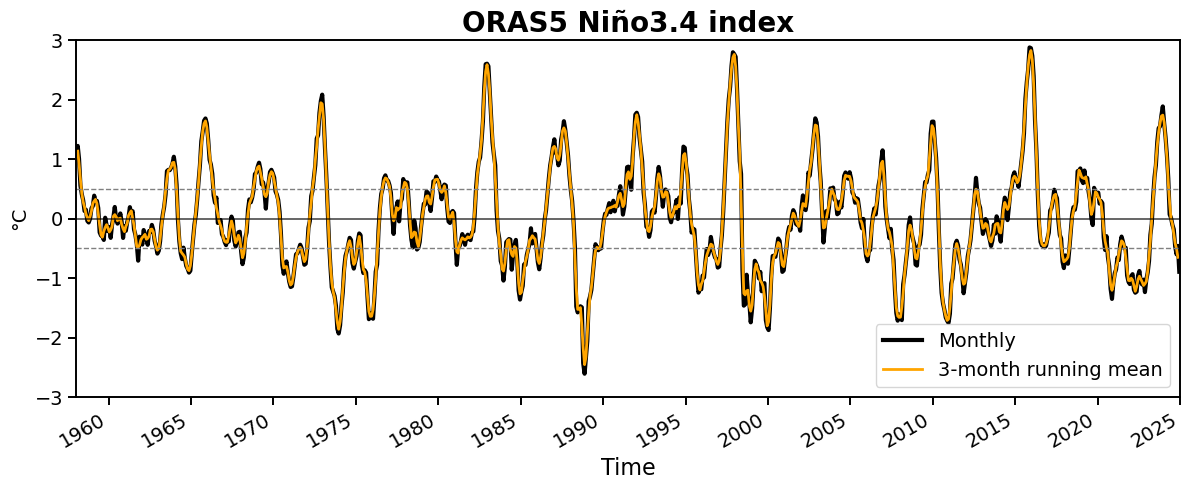

In [7]:
# Plot the Niño3.4 index

fig, ax = plt.subplots(figsize=(12,5))

Nino34_index_ORAS5.plot(ax=ax, lw=3, label="Monthly", color='k')
# also plot the 3-month running mean of the Niño3.4 index
Nino34_index_ORAS5.rolling(time_counter=3, center=True).mean().plot(
    ax=ax, lw=2, label="3-month running mean", color='orange'
)

# reference lines
ax.axhline(0,    color="k",    lw=1.2, alpha=0.7)
ax.axhline(0.5,  color="gray", ls="--", lw=1.0) # El Niño intensity threshold
ax.axhline(-0.5, color="gray", ls="--", lw=1.0) # La Niña intensity threshold

ax.set_title("ORAS5 Niño3.4 index", fontsize=20, fontweight="bold")
ax.set_ylabel('°C', fontsize=14)
ax.set_xlabel("Time", fontsize=16)

ax.tick_params(axis='both', labelsize=14, width=1.4, length=6)
for s in ax.spines.values():
    s.set_linewidth(1.4)

ax.legend(fontsize=14)

ax.set_xlim(Nino34_index_ORAS5.time_counter[0], Nino34_index_ORAS5.time_counter[-1])
ax.set_ylim(-3, 3)

years = np.arange(1960, 2026, 5)
ax.set_xticks([np.datetime64(f'{y}-01-01') for y in years])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

# 2. Calculate the state vectors for the Wyrtki-CSLIM fitting

## 2.1. EOF analysis for SSTa

In Wang et al. (in prep), the first nine principal components (PCs) of global SST anomalies over 40°S–30°N were used for the Wyrtki-CSLIM fitting. These PCs represent the **Hasselmann memory** — including ENSO mode and the damped persistence of SSTa outside the tropical Pacific that interact with ENSO.

This section provides details of the EOF analysis.

EOF analysis represents the anomaly field as a linear combination of spatial patterns (EOFs) and their associated time series (PCs):
$$
\text{SSTA}(t, \text{lat}, \text{lon}) \;\approx\; \sum_{k=1}^{K} \text{PC}_k(t) \, \text{EOF}_k(\text{lat}, \text{lon})
$$
Where:  
- $\text{SSTA}(t,\text{lat},\text{lon})$: anomaly field at time $t$  
- $\text{PC}_k(t)$: principal component (time series of mode $k$)  
- $\text{EOF}_k(\text{lat},\text{lon})$: spatial pattern of mode $k$  
- $K$: number of modes retained  



Note: The study employed a two-fold cross-validation to evaluate model forecast skill. Specifically, the 67-year ORAS5 dataset (1958–2024) was divided into two 33-year periods: 1958–1990 and 1992–2024, with 1991 reserved as a buffer year. Each model was trained on one segment and then used to hindcast the other. For skill metrics (ACC and RMSE), the two hindcast segments were concatenated, while the buffer year was excluded. Accordingly, the EOFs were computed on one segment, and the other segment was projected onto those EOFs, and vice versa.

In [8]:
lat1d = SSTa_40S30N['lat'].values
lon1d = SSTa_40S30N['lon'].values
data3d = SSTa_40S30N.values  # shape (T, Ny, Nx)
T, Ny, Nx = data3d.shape

In [9]:
# Run EOF analysis (uses sqrt(cos(lat)) weights)
n_modes_for_example = 10  # choose how many modes you want
pcs, eofs_flat, fve, mask2d = EOF(
    data=data3d,
    lat1d=lat1d,
    n_modes=n_modes_for_example,
    mask=None,          # auto: valid at ALL timesteps
    weight="sqrtcos"    # latitude weighting
)

Here, we plot the first 10 principal components (PCs) and corresponding EOF patterns derived from SST anomalies during 1958–2024 to provide an overview of their spatial and temporal structures.

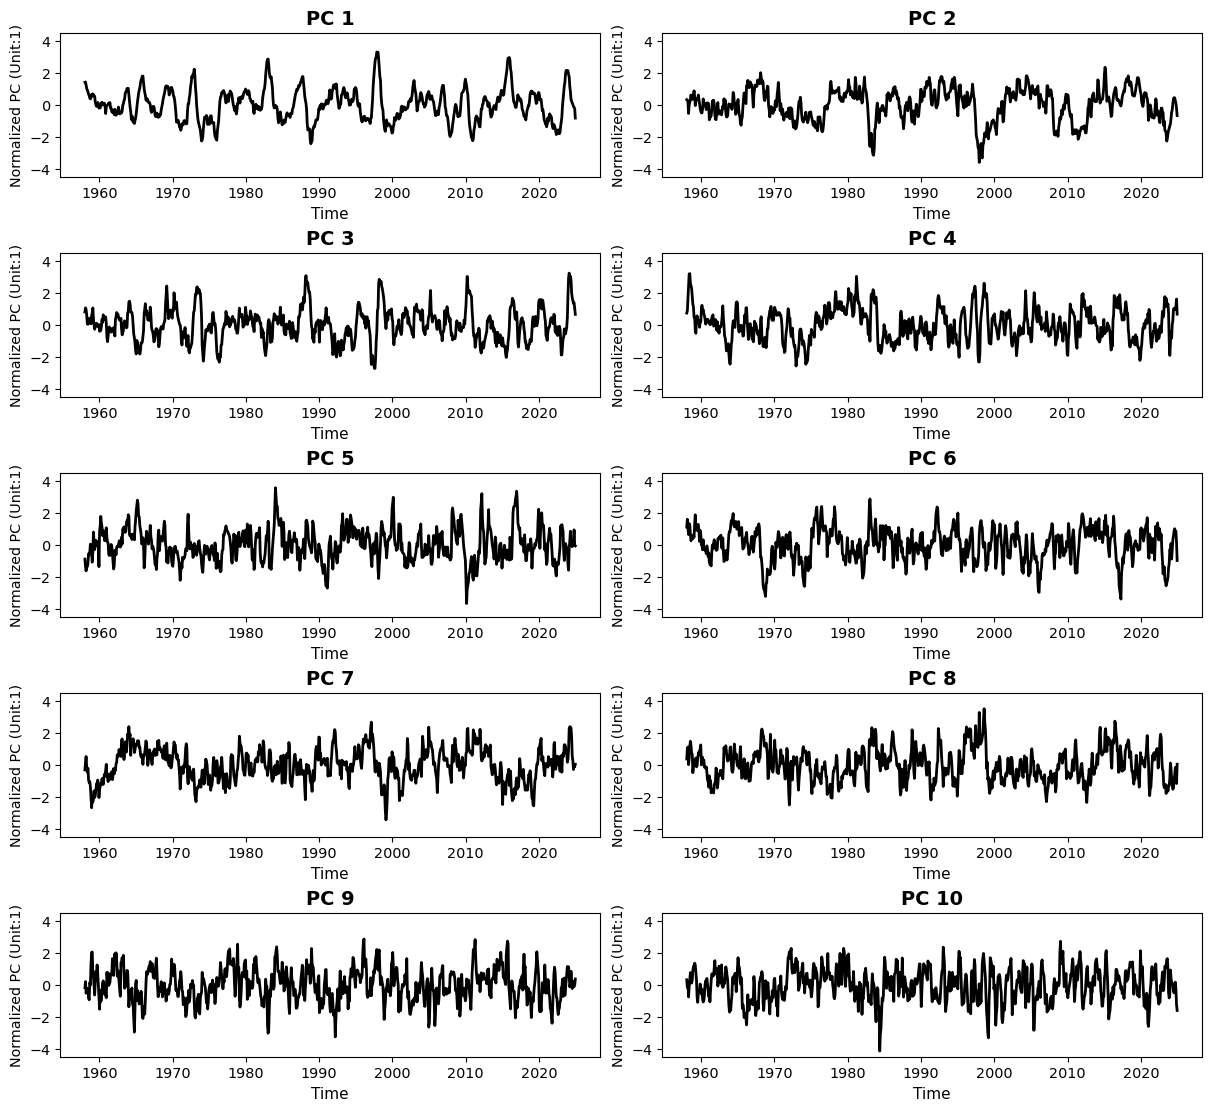

In [10]:
time = SSTa_40S30N['time_counter'].values

# Set up figure and axes
fig, axes = plt.subplots(5, 2, figsize=(12, 11), constrained_layout=True)
axes = axes.flatten()

for i in range(n_modes_for_example):
    ax = axes[i]

    # Normalize each PC (z-score)
    pc_norm = -pcs[:, i] / np.nanstd(pcs[:, i], ddof=1)

    ax.plot(time, pc_norm, color='k', linewidth=2)
    ax.set_ylim(-4.5, 4.5)

    ax.set_title(f'PC {i+1}', fontsize=14, fontweight='bold')
    ax.set_xlabel("Time", fontsize=11)
    ax.set_ylabel("Normalized PC (Unit:1)", fontsize=10.3)
    ax.tick_params(labelsize=10.3)

plt.show()


/tmp/ipykernel_1923713/3722591208.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r').copy(); cmap.set_bad(color='darkgrey')


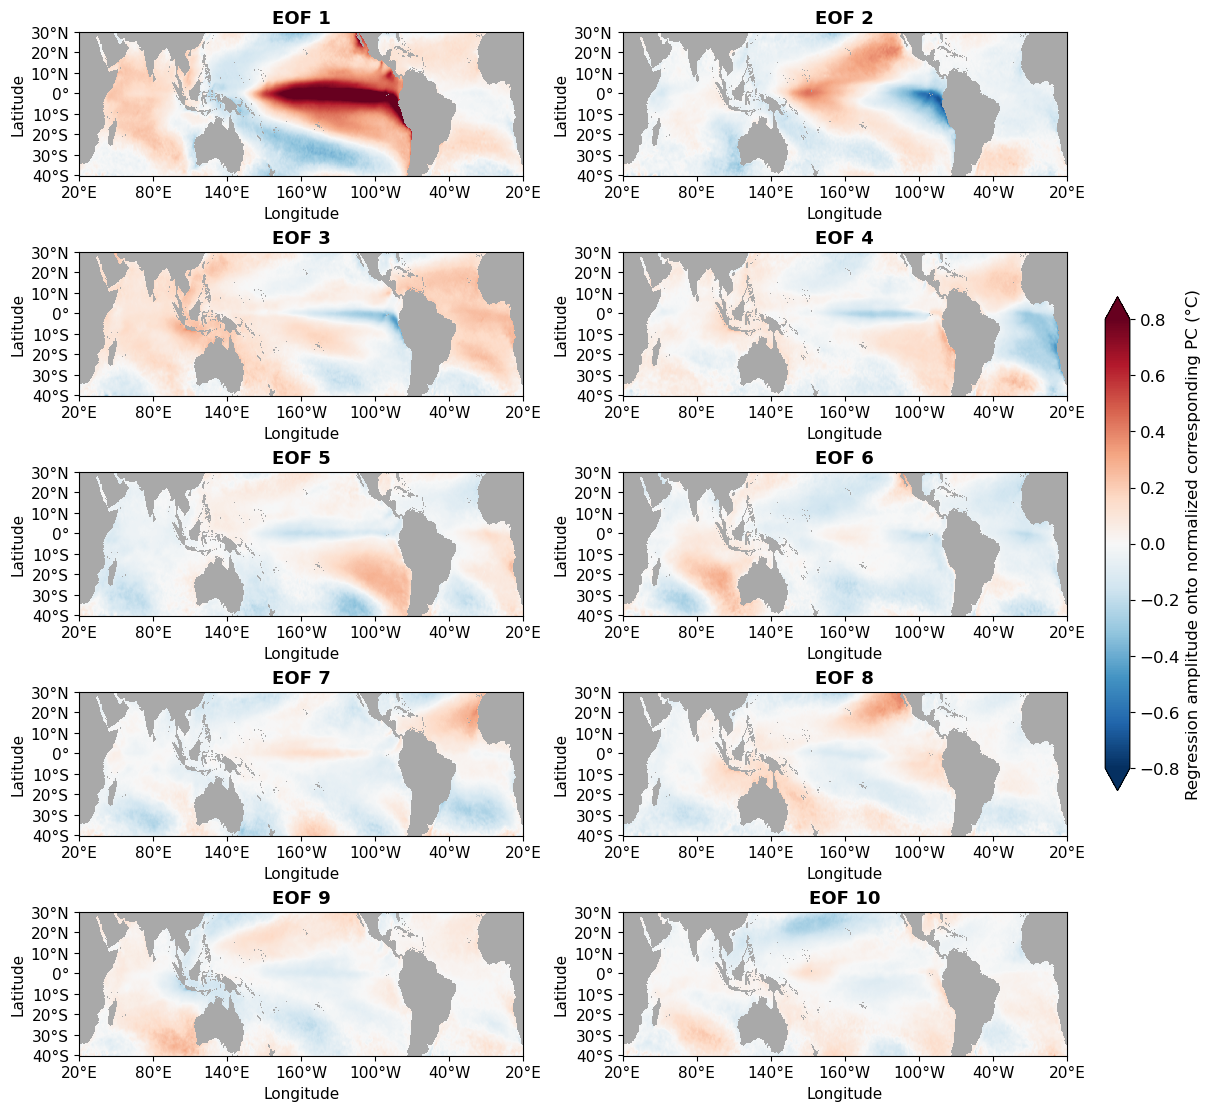

In [11]:
# Rebuild EOF patterns on (lat, lon) grid ---
eof_maps = []
for k in range(n_modes_for_example):
    eof2d = rebuild_eof_on_grid(eofs_flat[k, :], mask2d)  # (Ny, Nx)
    eof_maps.append(eof2d)
eof_maps = np.stack(eof_maps, axis=0)  # (n_modes_for_example, Ny, Nx)

keep = mask2d.ravel()
X_unw = data3d.reshape(T, Ny * Nx)[:, keep]  # unweighted anomalies on kept points (T, M)

nplot = min(n_modes_for_example, pcs.shape[1])
reg_maps = []
for k in range(nplot):
    pc = pcs[:, k]
    pc_z = (pc - pc.mean()) / pc.std(ddof=1)   # normalize PC
    beta_flat = (X_unw.T @ pc_z) / T           # regression coeffs (°C)
    beta_2d = np.full((Ny, Nx), np.nan, float)
    beta_2d[mask2d] = beta_flat
    reg_maps.append(beta_2d)
reg_maps = np.stack(reg_maps, axis=0)          # (nplot, Ny, Nx)

# plot the first 10 EOF patterns
fig, axes = plt.subplots(5, 2, figsize=(12, 11), constrained_layout=True)
axes = axes.flatten()

vmax = 0.8
vmin = -vmax
cmap = cm.get_cmap('RdBu_r').copy(); cmap.set_bad(color='darkgrey')

# --- keep your existing centering ---
central = 200.0  # degrees East
seam = (central - 180.0) % 360   # => 20°E
lon_e = (lon1d % 360)
lon_centered = (lon_e - seam) % 360
sort_idx = np.argsort(lon_centered)
lon_centered_sorted = lon_centered[sort_idx]
Lon_c, Lat = np.meshgrid(lon_centered_sorted, lat1d)

# --- plotting (unchanged except: remove the hard-coded xticks/labels) ---
for i in range(n_modes_for_example):
    ax = axes[i]
    if i < nplot:
        m = -reg_maps[i][:, sort_idx]
        pcm = ax.pcolormesh(Lon_c, Lat, m, cmap=cmap, shading='auto',
                            vmin=vmin, vmax=vmax)
        ax.set_title(f'EOF {i+1}', fontsize=13, fontweight='bold')
        ax.set_yticks([-40,-30,-20,-10,0,10,20,30])
        ax.set_yticklabels(['40°S','30°S','20°S','10°S','0°','10°N','20°N','30°N'], fontsize=11)
        ax.set_xlabel('Longitude', fontsize=11)
        ax.set_ylabel('Latitude', fontsize=11)
        ax.set_xlim(0, 360)
    else:
        ax.set_visible(False)

# --- seam-aware tick labels for ALL axes ---
tick_pos = np.arange(0, 361, 60)

def fmt_label(pos):
    # pos is in [0..360) of the "rotated" axis; convert back to true lon (degE)
    lon_true = (pos + seam) % 360
    # map to [-180, 180] and label with E/W
    x = ((lon_true + 180) % 360) - 180
    if abs(x) == 180 or x == 0:
        return f"{int(abs(x))}°"
    hemi = "E" if x > 0 else "W"
    return f"{int(abs(x))}°{hemi}"

for ax in axes[:nplot]:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels([fmt_label(p) for p in tick_pos], fontsize=11)

# colorbar (as you had)
cbar = fig.colorbar(pcm, ax=axes, orientation='vertical',
                    fraction=0.025, pad=0.02, extend='both')
cbar.set_label("Regression amplitude onto normalized corresponding PC (°C)", fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.show()


In [12]:
print(np.sum(fve[:9])) # total variance explained by the first 9 EOF modes

0.5547074942751696


In [13]:
# Split into two time periods for cross-validation
SSTa_40S30N_5890 = SSTa_40S30N.sel(time_counter=slice("1958-01", "1990-12"))
SSTa_40S30N_9224 = SSTa_40S30N.sel(time_counter=slice("1992-01", "2024-12"))

In [14]:
n_modes_for_LIM = 9

# A) Fit on 1958–1990; project 1992–2024
# Fit EOFs on 1958–1990 (training)
lat1d = SSTa_40S30N_5890['lat'].values

pcs_5890_from_5890_EOF, eofs_5890_flat, fve_5890, mask_5890 = EOF(
    data=SSTa_40S30N_5890.values,  # (T1, Ny, Nx)
    lat1d=lat1d,
    n_modes=n_modes_for_LIM,
    mask=None,          # auto: valid at ALL timesteps (intersection mask)
    weight="sqrtcos"    # latitude weighting used in fitting
)

# Project 1992–2024 (validation) onto the fitted EOFs
pcs_9224_from_5890_EOF = project_onto_eofs(
    data3d=SSTa_40S30N_9224.values,  # (T2, Ny, Nx)
    eofs=eofs_5890_flat,                  # (n_modes_for_LIM, M_kept)
    mask2d=mask_5890,                   # from fitting on 1958–1990
    lat1d=lat1d,                     # same latitude array as training
    weight="sqrtcos"                 # same weighting as training
)

# B) Fit on 1992–2024; project 1958–1990
# Fit EOFs on 1992–2024 (training)
lat1d = SSTa_40S30N_9224['lat'].values

pcs_9224_from_9224_EOF, eofs_9224_flat, fve_9224, mask_9224 = EOF(
    data=SSTa_40S30N_9224.values,  # (T2, Ny, Nx)
    lat1d=lat1d,
    n_modes=n_modes_for_LIM,
    mask=None,          # auto: valid at ALL timesteps (intersection mask)
    weight="sqrtcos"    # latitude weighting used in fitting
)

# Project 1958–1990 (validation) onto the fitted EOFs
pcs_5890_from_9224_EOF = project_onto_eofs(
    data3d=SSTa_40S30N_5890.values,  # (T1, Ny, Nx)
    eofs=eofs_9224_flat,             # (n_modes_for_LIM, M_kept)
    mask2d=mask_9224,                # from fitting on 1992–2024
    lat1d=lat1d,                     # same latitude array as training
    weight="sqrtcos"                 # same weighting as training
)


In [15]:
# total variance explained by the first 9 EOF modes
print(np.sum(fve_5890))
print(np.sum(fve_9224))

0.5983645363792546
0.5705367546923226


In [16]:
# get the flattened EOF pattern that represent the Nino3.4 region grids

# 1) Get lat/lon 2D arrays from your training cube
lat1d = SSTa_40S30N_5890['lat'].values
lon1d = SSTa_40S30N_5890['lon'].values
lon2d, lat2d = np.meshgrid(lon1d, lat1d)

# 2) Build Niño-3.4 mask on the ORIGINAL grid
# Latitude: 5S–5N
latmask = (lat2d >= -5) & (lat2d <= 5)
# Longitude: 170W–120W
lonmask = (lon2d >= -170) & (lon2d <= -120)

n34_mask_grid = latmask & lonmask

# 3) Intersect with EOF "kept" mask and map to kept/flattened indices
kept_flat_mask = mask_5890.ravel()                # full-grid → kept
kept_flat_idx   = np.flatnonzero(kept_flat_mask)  # positions (in full-grid flat) that were kept

# Build inverse map: full-grid-flat index -> kept index (or -1 if dropped)
inv_map = np.full(kept_flat_mask.size, -1, dtype=int)
inv_map[kept_flat_idx] = np.arange(kept_flat_idx.size, dtype=int)

# Grid indices inside Niño-3.4 that were ALSO kept
n34_grid_flat_idx = np.flatnonzero((n34_mask_grid & mask_5890).ravel())

# Kept-space indices for Niño-3.4
n34_kept_idx = inv_map[n34_grid_flat_idx]
n34_kept_idx = n34_kept_idx[n34_kept_idx >= 0]    # safety

## 2.2. Calculation of warm water volume proxy using basin-wide equatorial Pacific SSHa

In Wang et al. (2025), a key feature of the Wyrtki-CSLIM design is the inclusion of the warm water volume proxy using basin-wide equatorial Pacific SSHa, alongside the first nine PCs of global SST. This represents the **Wyrtki memory**, the recharge–discharge oscillation of equatorial Pacific upper-ocean heat content.

Note: The basin-wide equatorial Pacific region is defined as 5°N–5°S, 170°W–120°W. The area average is computed using latitude weights.

In [17]:
# Equatorial Pacific box: 120°E–80°W, 5°S–5°N
SSHa_WWV_box = SSHa_tropicalPacific.sel(
    lat=slice(-5, 5),
    lon=slice(120, 280)   # 120E → 280E (equivalent to 80W)
)

# calculate the WWV time series
SSHa_WWV_series = area_mean(
    SSHa_WWV_box,
    lat_bounds=(-5, 5),
    lon_bounds=(120, 280)   # 120°E to 80°W
)

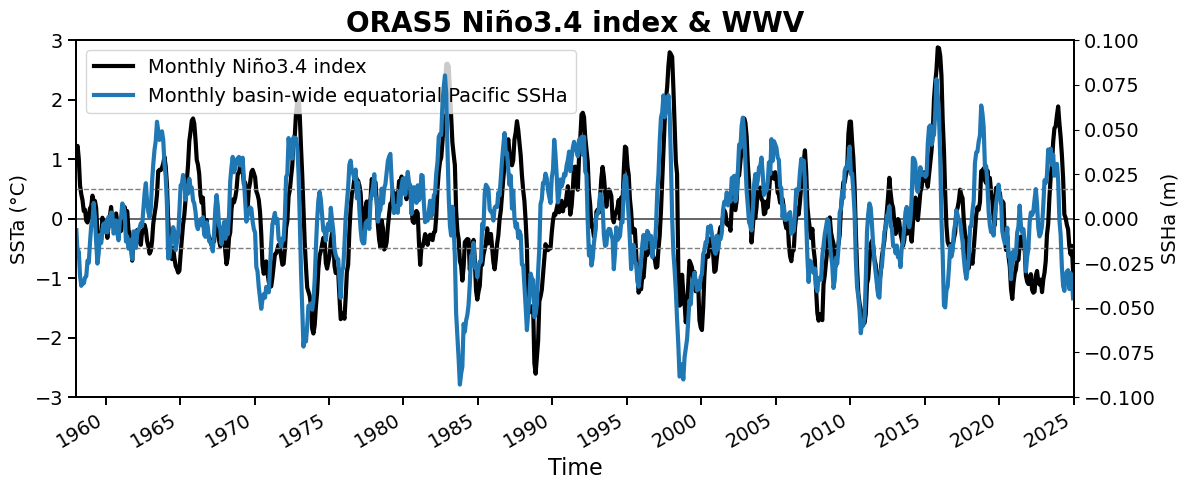

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,5))

# Left y-axis: Niño3.4 (°C)
Nino34_index_ORAS5.plot(ax=ax, lw=3, label="Monthly Niño3.4 index", color='k')
ax.axhline(0,    color="k",    lw=1.2, alpha=0.7)
ax.axhline(0.5,  color="gray", ls="--", lw=1.0) # El Niño intensity threshold
ax.axhline(-0.5, color="gray", ls="--", lw=1.0) # La Niña intensity threshold
ax.set_ylabel('SSTa (°C)', fontsize=14)
ax.set_ylim(-3, 3)

# Right y-axis: WWV (m)
ax2 = ax.twinx()
SSHa_WWV_series.plot(ax=ax2, lw=3, label="Monthly basin-wide equatorial Pacific SSHa", color='tab:blue')
ax2.set_ylabel('SSHa (m)', fontsize=14)
ax2.set_ylim(-0.1, 0.1)

# Titles, labels, ticks
ax.set_title("ORAS5 Niño3.4 index & WWV", fontsize=20, fontweight="bold")
ax.set_xlabel("Time", fontsize=16)
ax.tick_params(axis='both', labelsize=14, width=1.4, length=6)
ax2.tick_params(axis='y', labelsize=14)

for s in ax.spines.values():
    s.set_linewidth(1.4)
for s in ax2.spines.values():
    s.set_linewidth(1.4)

# X limits and ticks
ax.set_xlim(Nino34_index_ORAS5.time_counter[0], Nino34_index_ORAS5.time_counter[-1])
years = np.arange(1960, 2026, 5)
ax.set_xticks([np.datetime64(f'{y}-01-01') for y in years])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Combine legends from both axes
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, fontsize=14, loc='upper left')

plt.tight_layout()
plt.show()


# 3. Set up the state vector for the Wyrtki-CSLIM

The state vector $\mathbf{x}(t)$ used in the Wyrtki-CSLIM is defined as:
$$
\mathbf{x}(t) =
\begin{bmatrix}
\boldsymbol{\eta}_{\text{EqPac}}(t) \\
\mathbf{T}_{\text{PCs}}(t, 1\!-\!9)
\end{bmatrix}
$$
where:  
- $\boldsymbol{\eta}_{\text{EqPac}}(t)$: basin-averaged equatorial Pacific SSHa (warm water volume proxy)  
- $\mathbf{T}_{\text{PCs}}(t, 1\!-\!9)$: first nine PCs of global SST anomalies (40°S–30°N)  

In this section, we construct the state vector as defined above, with two additional steps:
1. Rescaling of $\boldsymbol{\eta}_{\text{EqPac}}(t)$:
We first normalize $\boldsymbol{\eta}_{\text{EqPac}}(t)$ by its own temporal standard deviation, and then multiply it by the standard deviation of $\mathbf{T}_{\text{PCs}}(t, 1\!-\!9)$ computed across the full state matrix.
This rescaling of $\boldsymbol{\eta}_{\text{EqPac}}(t)$ and $\mathbf{T}_{\text{PCs}}(t, 1\!-\!9)$ is to bring their magnitudes to a comparable level, thus minimizing potential bias on the LIM construction due to these scale differences.
2. Cyclostationary formulation:
For the Wyrtki-CSLIM fitting, the PCs are constructed separately for each calendar month, ensuring the model explicitly accounts for the seasonally varying background state.

In [19]:
SSTa_EOF_number_in_CSLIM = 9
state_vector_column_CSLIM = SSTa_EOF_number_in_CSLIM + 1 # the "1" represents the warm water volume proxy series

In [20]:
# Calculate the standard deviation of PCs based on EOF analysis of SSTa during 1958-1990
std_SSTa_pcs_5890_from_5890_EOF = pcs_5890_from_5890_EOF[:, :SSTa_EOF_number_in_CSLIM].std()
std_SSTa_pcs_9224_from_5890_EOF = pcs_9224_from_5890_EOF[:, :SSTa_EOF_number_in_CSLIM].std()
std_mean_SSTa_pcs_from_5890_EOF = np.nanmean([std_SSTa_pcs_5890_from_5890_EOF, std_SSTa_pcs_9224_from_5890_EOF])

# Rescale the basin-averaged equatorial Pacific SSHa by the standard deviation of PCs based on EOF analysis of SSTa during 1958-1990
SSHa_WWV_series_norm = SSHa_WWV_series / np.std(SSHa_WWV_series)
SSHa_WWV_series_rescaled_CSLIM1 = SSHa_WWV_series_norm * std_mean_SSTa_pcs_from_5890_EOF
# 1950-1990 and 1992-2024 are both 33 years
SSHa_WWV_series_rescaled_5890_CSLIM1 = SSHa_WWV_series_rescaled_CSLIM1.sel(time_counter=slice('1958-01','1990-12')).values
SSHa_WWV_series_rescaled_9224_CSLIM1 = SSHa_WWV_series_rescaled_CSLIM1.sel(time_counter=slice('1992-01','2024-12')).values

# CSLIM1 is trained on 1958-1990
pc_train_CSLIM1 = np.concatenate([SSHa_WWV_series_rescaled_5890_CSLIM1[None, :], pcs_5890_from_5890_EOF[:, :SSTa_EOF_number_in_CSLIM].T], axis=0)
pc_verif_CSLIM1 = np.concatenate([SSHa_WWV_series_rescaled_9224_CSLIM1[None, :], pcs_9224_from_5890_EOF[:, :SSTa_EOF_number_in_CSLIM].T], axis=0)
# pc_train_CSLIM1 and pc_verif_CSLIM1 are with shape (state_vector_column_CSLIM, time)

In [21]:
# Calculate the standard deviation of PCs based on EOF analysis of SSTa during 1958-1990
std_SSTa_pcs_5890_from_9224_EOF = pcs_5890_from_9224_EOF[:, :SSTa_EOF_number_in_CSLIM].std()
std_SSTa_pcs_9224_from_9224_EOF = pcs_9224_from_9224_EOF[:, :SSTa_EOF_number_in_CSLIM].std()
std_mean_SSTa_pcs_from_9224_EOF = np.mean([std_SSTa_pcs_5890_from_9224_EOF, std_SSTa_pcs_9224_from_9224_EOF])

# Rescale the basin-averaged equatorial Pacific SSHa by the standard deviation of PCs based on EOF analysis of SSTa during 1958-1990
SSHa_WWV_series_norm = SSHa_WWV_series / np.std(SSHa_WWV_series)
SSHa_WWV_series_rescaled_CSLIM2 = SSHa_WWV_series_norm * std_mean_SSTa_pcs_from_9224_EOF
# 1950-1990 and 1992-2024 are both 33 years
SSHa_WWV_series_rescaled_5890_CSLIM2 = SSHa_WWV_series_rescaled_CSLIM2.sel(time_counter=slice('1958-01','1990-12')).values
SSHa_WWV_series_rescaled_9224_CSLIM2 = SSHa_WWV_series_rescaled_CSLIM2.sel(time_counter=slice('1992-01','2024-12')).values

# CSLIM2 is trained on 1992-2024
pc_train_CSLIM2 = np.concatenate([SSHa_WWV_series_rescaled_9224_CSLIM2[None, :], pcs_9224_from_9224_EOF[:, :SSTa_EOF_number_in_CSLIM].T], axis=0)
pc_verif_CSLIM2 = np.concatenate([SSHa_WWV_series_rescaled_5890_CSLIM2[None, :], pcs_5890_from_9224_EOF[:, :SSTa_EOF_number_in_CSLIM].T], axis=0)
# pc_train_CSLIM2 and pc_verif_CSLIM2 are with shape (state_vector_column_CSLIM, time)

# 4. Wyrtki-CSLIM fitting

In this section, we describe the procedure for fitting the Wyrtki-CSLIM. The workflow consists of the following steps:
1. **State vector reshaping**: Adjust the shape of the state vector input so that it is organized separately for each calendar month.
2. **Initialization and model fitting**: Specify key parameters such as `period_T`, `tolerance_for_Q_negative_eigenvalue_number` to set up the CSLIM settings, and fit the state vector to obtain the CSLIM
3. **Stability check**: We will check: (1) if the monodromy matrices (`M_j`) are dissipative by computing the; (2) if the noise covariance matrices (`Qj`) is positive (semi)definite. As long as no error pops up, the CSLIM is stable.

Note: Following Wang et al. (2025), we apply two-fold cross-validation. Accordingly, two Wyrtki-CSLIMs are trained here. We split the 67-year ORAS5 dataset (1958–2024) into two 33-year periods: 1958–1990 and 1992–2024, with 1991 as a buffer. We trained each model on one-fold and used it to hindcast the other period. 
1. **Wyrtki-CSLIM1**: trained on the state vector during 1958-1990
2. **Wyrtki-CSLIM2**: trained on the state vector during 1992-2024

The only difference between them is the training epoch of the state vector, all other settings are identical.

In [22]:
# Reshape the state vectors by calendar month
pc_train_reshaped_CSLIM1 = reshape_state_vector(pc_train_CSLIM1)
pc_verif_reshaped_CSLIM1 = reshape_state_vector(pc_verif_CSLIM1)
pc_train_reshaped_CSLIM2 = reshape_state_vector(pc_train_CSLIM2)
pc_verif_reshaped_CSLIM2 = reshape_state_vector(pc_verif_CSLIM2)

# Verify the reshaped dimensions, should be with shape (spatial_length, n_cycles, period_T)
print("pc_train_reshaped_CSLIM1:", pc_train_reshaped_CSLIM1.shape)
print("pc_verif_reshaped_CSLIM1:", pc_verif_reshaped_CSLIM1.shape)
print("pc_train_reshaped_CSLIM2:", pc_train_reshaped_CSLIM2.shape)
print("pc_verif_reshaped_CSLIM2:", pc_verif_reshaped_CSLIM2.shape)

pc_train_reshaped_CSLIM1: (10, 33, 12)
pc_verif_reshaped_CSLIM1: (10, 33, 12)
pc_train_reshaped_CSLIM2: (10, 33, 12)
pc_verif_reshaped_CSLIM2: (10, 33, 12)


In [23]:
# Initialize and fit Wyrtki-CSLIM with specified settings:

#   - x_CSLIM_training: State vector for CSLIM training, shape: (spatial_length, n_cycles, period_T)
#   - period_T: seasonal cycle length (12 months)
#   - tolerance_for_Q_negative_eigenvalue_number: threshold for handling negative eigenvalues

period_T = 12
tolerance_for_Q_negative_eigenvalue_number = 0.5

Wyrtki_CSLIM1 = CSLIM(pc_train_reshaped_CSLIM1, period_T = period_T, tolerance_for_Q_negative_eigenvalue_number = tolerance_for_Q_negative_eigenvalue_number)
Wyrtki_CSLIM2 = CSLIM(pc_train_reshaped_CSLIM2, period_T = period_T, tolerance_for_Q_negative_eigenvalue_number = tolerance_for_Q_negative_eigenvalue_number)

# Both CSLIM1 and CSLIM2 will use these settings in the following steps

**Stability checks**
1. Check if the monodromy matrices `Mj` are dissipative
2. Check if the noise covariance matrices `Qj` is positive (semi)definite

In [24]:
# Wyrtki_CSLIM1 stability check:
monodromy_matrix_Mj_CSLIM1 = Wyrtki_CSLIM1.monodromy_matrix_Mj()
Qj_CSLIM1, Qj_eigenvalues_CSLIM1, Qj_eigenvectors_CSLIM1, Qj_original_negtive_eigenvalue_number_CSLIM1, Qj_original_CSLIM1, Qj_original_eigenvalues_CSLIM1 = Wyrtki_CSLIM1.noise_covariance_Qj()

/tmp/ipykernel_1923713/1448588601.py:3: RuntimeWarning: Adjusted Q1: negative eigenvalues were clipped to 0 and positive eigenvalues were rescaled to preserve tr(Qj).
  Qj_CSLIM1, Qj_eigenvalues_CSLIM1, Qj_eigenvectors_CSLIM1, Qj_original_negtive_eigenvalue_number_CSLIM1, Qj_original_CSLIM1, Qj_original_eigenvalues_CSLIM1 = Wyrtki_CSLIM1.noise_covariance_Qj()
/tmp/ipykernel_1923713/1448588601.py:3: RuntimeWarning: Adjusted Q2: negative eigenvalues were clipped to 0 and positive eigenvalues were rescaled to preserve tr(Qj).
  Qj_CSLIM1, Qj_eigenvalues_CSLIM1, Qj_eigenvectors_CSLIM1, Qj_original_negtive_eigenvalue_number_CSLIM1, Qj_original_CSLIM1, Qj_original_eigenvalues_CSLIM1 = Wyrtki_CSLIM1.noise_covariance_Qj()
/tmp/ipykernel_1923713/1448588601.py:3: RuntimeWarning: Adjusted Q3: negative eigenvalues were clipped to 0 and positive eigenvalues were rescaled to preserve tr(Qj).
  Qj_CSLIM1, Qj_eigenvalues_CSLIM1, Qj_eigenvectors_CSLIM1, Qj_original_negtive_eigenvalue_number_CSLIM1, Qj_

In [25]:
# Wyrtki_CSLIM2 stability check:
monodromy_matrix_Mj_CSLIM2 = Wyrtki_CSLIM2.monodromy_matrix_Mj()
Qj_CSLIM2, Qj_eigenvalues_CSLIM2, Qj_eigenvectors_CSLIM2, Qj_original_negtive_eigenvalue_number_CSLIM2, _, _ = Wyrtki_CSLIM2.noise_covariance_Qj()

/tmp/ipykernel_1923713/901375198.py:3: RuntimeWarning: Adjusted Q1: negative eigenvalues were clipped to 0 and positive eigenvalues were rescaled to preserve tr(Qj).
  Qj_CSLIM2, Qj_eigenvalues_CSLIM2, Qj_eigenvectors_CSLIM2, Qj_original_negtive_eigenvalue_number_CSLIM2, _, _ = Wyrtki_CSLIM2.noise_covariance_Qj()
/tmp/ipykernel_1923713/901375198.py:3: RuntimeWarning: Adjusted Q2: negative eigenvalues were clipped to 0 and positive eigenvalues were rescaled to preserve tr(Qj).
  Qj_CSLIM2, Qj_eigenvalues_CSLIM2, Qj_eigenvectors_CSLIM2, Qj_original_negtive_eigenvalue_number_CSLIM2, _, _ = Wyrtki_CSLIM2.noise_covariance_Qj()
/tmp/ipykernel_1923713/901375198.py:3: RuntimeWarning: Adjusted Q3: negative eigenvalues were clipped to 0 and positive eigenvalues were rescaled to preserve tr(Qj).
  Qj_CSLIM2, Qj_eigenvalues_CSLIM2, Qj_eigenvectors_CSLIM2, Qj_original_negtive_eigenvalue_number_CSLIM2, _, _ = Wyrtki_CSLIM2.noise_covariance_Qj()
/tmp/ipykernel_1923713/901375198.py:3: RuntimeWarning: 

# 5. Deterministic hindcasts for ENSO using the Wyrtki-CSLIM

In this section, we generate deterministic hindcasts for ENSO using the Wyrtki-CSLIM.

Hindcast setup:
x_forecast_from, x_forecast_from_j_index, lead_tau_forecast

- `x_forecast_from`: The state vector you  want to forecast from (in the PCs space); Size: [self.spatial_length, 1] or [self.spatial_length,].
- `x_forecast_from_j_index` = The phase index j that the first of the x_forecast_from is.
- `lead_tau_forecast`: Lead time(s) τ for the forecast.

Hindcast experiments:
- For the hindcast between 1992-2024, Wyrtki-CSLIM1 (trained on the state vector during 1958–1990) is used to make the hindcast.
- For the hindcast between 1958–1990, Wyrtki-CSLIM2 (trained on the state vector during 1992-2024) is used to make the hindcast.

Forecast procedure:

For each verification sample:
- Loop over the available initial conditions (icycle).
- Loop over the calendar months (imonth).
- Store results in a 4-D array with dimensions: `(forecast_tau, spatial_length, n_time_for_each_phase, period_T)`


Forecast outputs:
- `forecast_Wyrtki_CSLIM1` (EOF/PC space): hindcasts for the 1992–2024 verification period, using Wyrtki-CSLIM1.  
- `forecast_Wyrtki_CSLIM2` (EOF/PC space): hindcasts for the 1958–1990 verification period, using Wyrtki-CSLIM2.  
- `SSTa_forecast_Wyrtki_CSLIM1_grid` (lat/lon space): SSTa hindcasts for the 1992–2024 verification period.
- `SSTa_forecast_Wyrtki_CSLIM2_grid` (lat/lon space): SSTa hindcasts for the 1958–1990 verification period.

Note: `SSTa_forecast_Wyrtki_CSLIM1_grid` and `SSTa_forecast_Wyrtki_CSLIM2_grid` are obtained by projecting the state vector components corresponding to SSTa PCs onto their associated EOF patterns and summing the contributions to reconstruct the SSTa field on the regular latitude-longitude grid.  

In [26]:
import time
t_count = time.perf_counter()

# Define dimensions
spatial_length = pc_train_reshaped_CSLIM1.shape[0]
n_time_for_each_phase = pc_train_reshaped_CSLIM1.shape[1]
lead_tau_forecast = np.arange(1,21+1)  # forecast lead time in months

# Allocate forecast PC arrays
# Allocate array for hindcasts of pc_verif_reshaped_CSLIM1 (1992–2024), derived from Wyrtki-CSLIM1 (trained on 1958–1990)
forecast_Wyrtki_CSLIM1 = np.full((lead_tau_forecast.shape[0], spatial_length, n_time_for_each_phase, period_T), np.nan)
# Allocate array for hindcasts of pc_verif_reshaped_CSLIM2 (1958–1990), derived from Wyrtki-CSLIM2 (trained on 1992–2024)
forecast_Wyrtki_CSLIM2 = np.full((lead_tau_forecast.shape[0], spatial_length, n_time_for_each_phase, period_T), np.nan)

# Run deterministic hindcasts (PC space)
for icycle in range(n_time_for_each_phase):
    for imonth in np.arange(1,period_T+1): 
        # np.arange gives NumPy integer scalars (e.g., np.int64), make sure it is int
        imonth = int(imonth)

        forecast_Wyrtki_CSLIM1[:, :, icycle, imonth-1] = Wyrtki_CSLIM1.deterministic_forecast(
            x_forecast_from=pc_verif_reshaped_CSLIM1[:, icycle, imonth-1],
            x_forecast_from_j_index=imonth,
            lead_tau_forecast=lead_tau_forecast
        )            
        forecast_Wyrtki_CSLIM2[:, :, icycle, imonth-1] = Wyrtki_CSLIM2.deterministic_forecast(
            x_forecast_from=pc_verif_reshaped_CSLIM2[:, icycle, imonth-1],
            x_forecast_from_j_index=imonth,
            lead_tau_forecast=lead_tau_forecast
        )

print(f"Total time: {time.perf_counter() - t_count:.2f}s")

/tmp/ipykernel_1923713/1163502884.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  forecast_Wyrtki_CSLIM1[:, :, icycle, imonth-1] = Wyrtki_CSLIM1.deterministic_forecast(
/tmp/ipykernel_1923713/1163502884.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  forecast_Wyrtki_CSLIM2[:, :, icycle, imonth-1] = Wyrtki_CSLIM2.deterministic_forecast(


Total time: 8.22s


In [27]:
t_count = time.perf_counter()

# Reconstruct SSTa (kept/flattened grid space)
ocean_grid_number = eofs_5890_flat.shape[1]
SSTa_forecast_Wyrtki_CSLIM1_grid = np.full((lead_tau_forecast.shape[0], ocean_grid_number, n_time_for_each_phase, period_T), np.nan)
SSTa_forecast_Wyrtki_CSLIM2_grid = np.full((lead_tau_forecast.shape[0], ocean_grid_number, n_time_for_each_phase, period_T), np.nan)

for icycle in range(n_time_for_each_phase):
    for imonth in range(period_T):    
        for itau in range(lead_tau_forecast.shape[0]):
            SSTa_forecast_Wyrtki_CSLIM1_grid_icycle_imonth_itau = np.zeros(ocean_grid_number)
            SSTa_forecast_Wyrtki_CSLIM2_grid_icycle_imonth_itau = np.zeros(ocean_grid_number)
            for ieof in range(SSTa_EOF_number_in_CSLIM):
                # forecast_CSLIM1[ieof+1,...] is because index 0 holds WWV, not an SST PC, SST PCs start at index 1
                # CSLIM1 uses eofs_9224_flat, and CSLIM2 uses eofs_5890_flat
                SSTa_forecast_Wyrtki_CSLIM1_grid_icycle_imonth_itau = SSTa_forecast_Wyrtki_CSLIM1_grid_icycle_imonth_itau + forecast_Wyrtki_CSLIM1[itau, ieof+1, icycle, imonth]*eofs_5890_flat[ieof]
                SSTa_forecast_Wyrtki_CSLIM2_grid_icycle_imonth_itau = SSTa_forecast_Wyrtki_CSLIM2_grid_icycle_imonth_itau + forecast_Wyrtki_CSLIM2[itau, ieof+1, icycle, imonth]*eofs_9224_flat[ieof]
            SSTa_forecast_Wyrtki_CSLIM1_grid[itau, :, icycle, imonth] = SSTa_forecast_Wyrtki_CSLIM1_grid_icycle_imonth_itau
            SSTa_forecast_Wyrtki_CSLIM2_grid[itau, :, icycle, imonth] = SSTa_forecast_Wyrtki_CSLIM2_grid_icycle_imonth_itau

print(f"Total time: {time.perf_counter() - t_count:.2f}s")

Total time: 178.63s


In [28]:
# only exact those grids within the Nino34 region, use the n34_kept_idx mask we defined above
SSTa_forecast_Wyrtki_CSLIM1_grid_N34 = SSTa_forecast_Wyrtki_CSLIM1_grid[:,n34_kept_idx,:,:]
SSTa_forecast_Wyrtki_CSLIM2_grid_N34 = SSTa_forecast_Wyrtki_CSLIM2_grid[:,n34_kept_idx,:,:]

# get the original weight within the Nino34 region
_, orinigial_weight_array, _ = flatten_mask_weight(SSTa_40S30N_5890, SSTa_40S30N_5890.lat.values, mask=None, weight="sqrtcos")
orinigial_weight_array_N34 = orinigial_weight_array[n34_kept_idx]

# These fields are still sqrt(cosφ)-weighted. For a true area average, first unweight (÷ sqrt(cosφ)), and then take a cosφ-weighted mean
# For spatial patterns/maps, unweight before plotting as well.
SSTa_forecast_Wyrtki_CSLIM1_grid_N34_unweighted = SSTa_forecast_Wyrtki_CSLIM1_grid_N34/orinigial_weight_array_N34[None, :, None, None]
SSTa_forecast_Wyrtki_CSLIM2_grid_N34_unweighted = SSTa_forecast_Wyrtki_CSLIM2_grid_N34/orinigial_weight_array_N34[None, :, None, None]
# Area-mean weights = cosφ = (sqrt(cosφ))**2
new_weight_array_N34 = orinigial_weight_array_N34**2

# SSTa_forecast_Wyrtki_CSLIM1_Nino34_index is the Niño3.4 index hindcast between 1992-2024
SSTa_forecast_Wyrtki_CSLIM1_Nino34_index = np.nanmean(SSTa_forecast_Wyrtki_CSLIM1_grid_N34_unweighted * new_weight_array_N34[None, :, None, None], axis=1)
# SSTa_forecast_Wyrtki_CSLIM2_Nino34_index is the Niño3.4 index hindcast between 1958-1991
SSTa_forecast_Wyrtki_CSLIM2_Nino34_index = np.nanmean(SSTa_forecast_Wyrtki_CSLIM2_grid_N34_unweighted * new_weight_array_N34[None, :, None, None], axis=1)


In [29]:
# make the time axis continuously
SSTa_forecast_Wyrtki_CSLIM1_Nino34_index_full = np.full((lead_tau_forecast.shape[0], n_time_for_each_phase * period_T), np.nan)
SSTa_forecast_Wyrtki_CSLIM2_Nino34_index_full = np.full((lead_tau_forecast.shape[0], n_time_for_each_phase * period_T), np.nan)
for iyr in range(n_time_for_each_phase):
    SSTa_forecast_Wyrtki_CSLIM1_Nino34_index_full[:,iyr*12:(iyr+1)*12] = SSTa_forecast_Wyrtki_CSLIM1_Nino34_index[:,iyr]
    SSTa_forecast_Wyrtki_CSLIM2_Nino34_index_full[:,iyr*12:(iyr+1)*12] = SSTa_forecast_Wyrtki_CSLIM2_Nino34_index[:,iyr]

# smooth with a 3-month running mean along
SSTa_forecast_Wyrtki_CSLIM1_Nino34_index_smoothed = np.full_like(SSTa_forecast_Wyrtki_CSLIM1_Nino34_index_full, np.nan)
SSTa_forecast_Wyrtki_CSLIM2_Nino34_index_smoothed = np.full_like(SSTa_forecast_Wyrtki_CSLIM2_Nino34_index_full, np.nan)
# Smoothing kernel
kernel = np.ones(3) / 3
for itau in range(lead_tau_forecast.shape[0]):
    SSTa_forecast_Wyrtki_CSLIM1_Nino34_index_smoothed[itau,:] = convolve(SSTa_forecast_Wyrtki_CSLIM1_Nino34_index_full[itau,:], kernel, mode='nearest')
    SSTa_forecast_Wyrtki_CSLIM2_Nino34_index_smoothed[itau,:] = convolve(SSTa_forecast_Wyrtki_CSLIM2_Nino34_index_full[itau,:], kernel, mode='nearest')


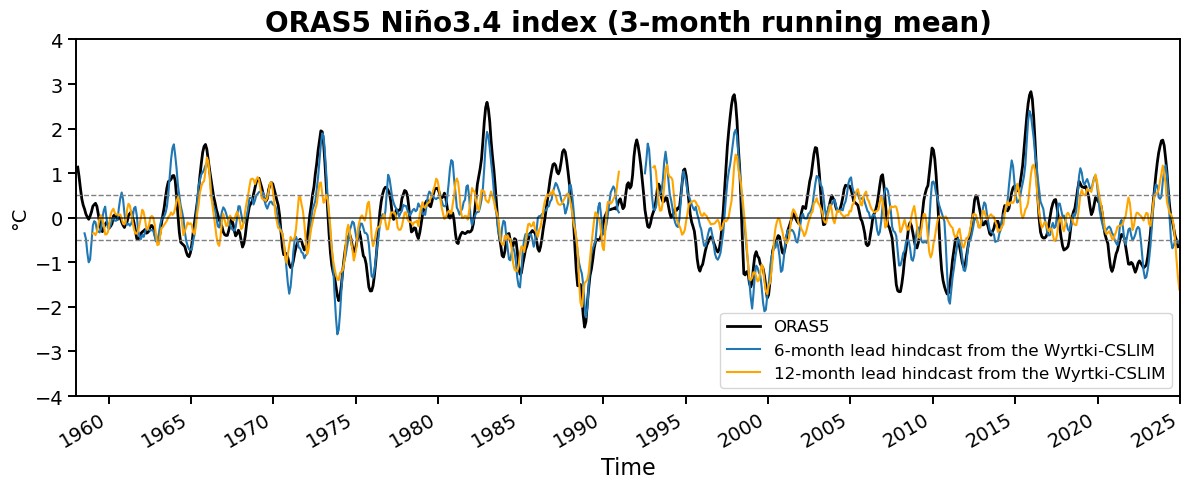

In [30]:
# Plot the Niño3.4 index

fig, ax = plt.subplots(figsize=(12,5))  # a bit bigger canvas

Nino34_index_ORAS5.rolling(time_counter=3, center=True).mean().plot(
    ax=ax, lw=2, label="ORAS5", color='k'
)

ax.plot(SSTa_40S30N_5890.time_counter.values[6:],SSTa_forecast_Wyrtki_CSLIM2_Nino34_index_smoothed[6-1,:-6], color='tab:blue',label='6-month lead hindcast from the Wyrtki-CSLIM')
ax.plot(SSTa_40S30N_9224.time_counter.values[6:],SSTa_forecast_Wyrtki_CSLIM1_Nino34_index_smoothed[6-1,:-6], color='tab:blue')

ax.plot(SSTa_40S30N_5890.time_counter.values[12:],SSTa_forecast_Wyrtki_CSLIM2_Nino34_index_smoothed[12-1,:-12], color='orange',label='12-month lead hindcast from the Wyrtki-CSLIM')
ax.plot(SSTa_40S30N_9224.time_counter.values[12:],SSTa_forecast_Wyrtki_CSLIM1_Nino34_index_smoothed[12-1,:-12], color='orange')

# reference lines
ax.axhline(0,    color="k",    lw=1.2, alpha=0.7)
ax.axhline(0.5,  color="gray", ls="--", lw=1.0) # El Niño intensity threshold
ax.axhline(-0.5, color="gray", ls="--", lw=1.0) # La Niña intensity threshold

ax.set_title("ORAS5 Niño3.4 index (3-month running mean)", fontsize=20, fontweight="bold")
ax.set_ylabel('°C', fontsize=14)
ax.set_xlabel("Time", fontsize=16)

ax.tick_params(axis='both', labelsize=14, width=1.4, length=6)
for s in ax.spines.values():
    s.set_linewidth(1.4)

ax.legend(fontsize=12)

# limits
ax.set_xlim(Nino34_index_ORAS5.time_counter[0], Nino34_index_ORAS5.time_counter[-1])
ax.set_ylim(-4, 4)

# x ticks from 1960 to 2025 (every 5 years)
years = np.arange(1960, 2026, 5)
ax.set_xticks([np.datetime64(f'{y}-01-01') for y in years])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

# 6. Evaluate Wyrtki-CSLIM's forecast skill of Niño3.4 index

In this section, we calculate the Niño3.4 index from ERSSTv5 (observed SST) for 1958–2024.
Although the Wyrtki-CSLIMs are trained on ORAS5 data, and Niño3.4 forecasts are initialized from ORAS5, ORAS5 is a reanalysis product. To ensure a proper validation, it is preferable to compare against observational data. Therefore, the Niño3.4 index from ERSSTv5 is used to evaluate Wyrtki-CSLIM forecast skill by anomaly correlation coefficient (ACC) and root mean square error (RMSE) .

The Niño3.4 index from ERSSTv5 is derived as follows:
1. Read ERSSTv5 from NOAA website, remove the quadratic trend and the 21-year running-mean climatology using the function `compute_gridwise_quadratic_detrended_running_climatology_anomaly`, and calculate the area-averaged SST anomalies over the Niño3.4 region with latitude weighting.
2. Calculate the ACC and RMSE between the Niño3.4 index from the hindcasts from the Wyrtki-CSLIM and ERSSTv5.

## 6.1. Calculate the Niño3.4 index from the ERSSTv5

In [31]:
t_count = time.perf_counter()

# Get SST ERSSTv5 on NOAA website
url_ersstv5 = "https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"
# https://psl.noaa.gov/thredds/fileServer/Datasets/noaa.ersst.v5/sst.mnmean.nc
ERSST = xr.open_dataset(url_ersstv5)
ERSST = ERSST['sst']
# Make the time selection
ERSST_5824 = ERSST.sel(time=slice('1958-01','2024-12'))

print(f"Total time: {time.perf_counter() - t_count:.2f}s")

Total time: 1.10s


In [32]:
# sort latitudes and longitudes
ERSST_5824_sort = ERSST_5824.assign_coords(lon=(ERSST_5824.lon % 360)).sortby(["lat", "lon"])

# calculate the SSTa
ERSST_5824_quadratic_detrend_21yr_rmclim = compute_gridwise_quadratic_detrended_running_climatology_anomaly(ERSST_5824_sort, time_dim='time', clim_years=21)

# Calculate Niño3.4
# Define latitude and longitude bounds
lat_bnds = (-5, 5)
lon_bnds = (190, 240)

ERSSTa_Nino34_index_quadratic_detrend_21yr_rmclim_19582024 = area_mean(ERSST_5824_quadratic_detrend_21yr_rmclim, lat_bnds, lon_bnds)

## 6.2 Wyrtki-CSLIM skill asessment for Niño3.4 forecast

Notes:
- To assess ENSO forecast skill, we use two metrics: (1) anomaly correlation coefficient (ACC) and (2) root mean square error (RMSE) between the 3-month-running-mean smoothed Niño3.4 index from ERSSTv5 and model hindcasts. Higher ACC and lower RMSE indicate better skill.
- Model forecast skills were determined using a two-fold cross-validation assessment. We split the 67-year ORAS5 dataset (1958–2024) into two 33-year periods: 1958–1990 and 1992–2024, with 1991 as a buffer. We trained each model on one-fold and used it to hindcast the other period. When computing ACC and RMSE, the two hindcast segments were concatenated, with the buffer year 1991 left missing.

In [33]:
# Concatenated two hindcast segments, with the buffer year 1991 left missing

# Function to concat with 12 NaNs in between
def concat_with_nan_gap(forecast1, forecast2, n_gap=12):
    gap = np.full((forecast1.shape[0],n_gap), np.nan)
    return np.concatenate([forecast2, gap, forecast1], axis=1)

SSTa_forecast_Wyrtki_CSLIM_Nino34_index_smoothed = concat_with_nan_gap(
    SSTa_forecast_Wyrtki_CSLIM1_Nino34_index_smoothed, SSTa_forecast_Wyrtki_CSLIM2_Nino34_index_smoothed)


In [34]:
from scipy.ndimage import convolve
kernel = np.ones(3) / 3
ERSSTa_Nino34_index_quadratic_detrend_21yr_rmclim_19582024_smoothed = convolve(ERSSTa_Nino34_index_quadratic_detrend_21yr_rmclim_19582024.values, kernel, mode='nearest')

In [35]:
ACC_Wyrtki_CSLIM = np.zeros(lead_tau_forecast.shape[0])
ACC_pvalue_Wyrtki_CSLIM = np.zeros(lead_tau_forecast.shape[0])
RMSE_Wyrtki_CSLIM = np.zeros(lead_tau_forecast.shape[0])

for itau in lead_tau_forecast:
    ACC_Wyrtki_CSLIM[itau - 1] = t_statistic(ERSSTa_Nino34_index_quadratic_detrend_21yr_rmclim_19582024_smoothed[itau:], SSTa_forecast_Wyrtki_CSLIM_Nino34_index_smoothed[itau-1,:-itau], 1)[0]
    ACC_pvalue_Wyrtki_CSLIM[itau - 1] = t_statistic(ERSSTa_Nino34_index_quadratic_detrend_21yr_rmclim_19582024_smoothed[itau:], SSTa_forecast_Wyrtki_CSLIM_Nino34_index_smoothed[itau-1,:-itau], 1)[-1]
    RMSE_Wyrtki_CSLIM[itau - 1] = calculate_rms(ERSSTa_Nino34_index_quadratic_detrend_21yr_rmclim_19582024_smoothed[itau:] - SSTa_forecast_Wyrtki_CSLIM_Nino34_index_smoothed[itau-1,:-itau])


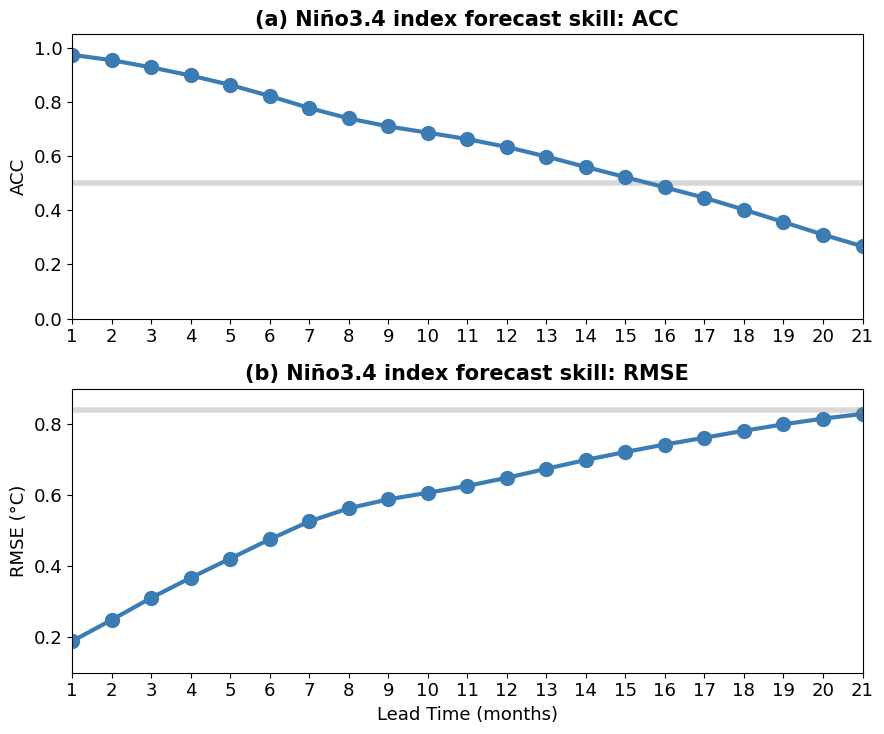

In [36]:
# Define lead times
x = np.arange(1, 21+1)

# Set global font sizes
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 15,
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 9,
    'lines.linewidth': 2
})

fig, axs = plt.subplots(2, 1, figsize=(9, 7.5))

# --- (a) ACC Plot ---
axs[0].plot(x, np.ones_like(x) * 0.5, color='grey', linewidth=4, alpha=0.3)
# Plot lines
axs[0].plot(x, ACC_Wyrtki_CSLIM, linestyle='-', color='#3a7cb3', marker='o', markerfacecolor='#3a7cb3',
            markeredgecolor='#3a7cb3', linewidth=3, markersize=10, label='Wyrtki-CSLIM')

axs[0].set_xlim(1, 21)
axs[0].set_ylim(0, 1.05)
axs[0].set_ylabel("ACC")
axs[0].set_title("(a) Niño3.4 index forecast skill: ACC", fontweight='bold')
axs[0].set_xticks(x)

# --- (b) RMS Plot ---
axs[1].plot(x, RMSE_Wyrtki_CSLIM, linestyle='-', color='#3a7cb3', marker='o', markerfacecolor='#3a7cb3',
            markeredgecolor='#3a7cb3', linewidth=3, markersize=10, label='Wyrtki-CSLIM')

axs[1].plot(x, np.ones_like(x)*np.std(ERSSTa_Nino34_index_quadratic_detrend_21yr_rmclim_19582024_smoothed), color='grey', linewidth=4, alpha=0.3)

axs[1].set_xlim(1, 21)
axs[1].set_ylim(0.1, 0.9)
axs[1].set_xlabel("Lead Time (months)")
axs[1].set_ylabel("RMSE (°C)")
axs[1].set_title("(b) Niño3.4 index forecast skill: RMSE", fontweight='bold')
axs[1].set_xticks(x)

plt.tight_layout()
plt.show()


# 7. Real time forecast

In this section, we will use the Wyrtki-CSLIM to make the real-time forecast for the 3-month running mean smoothed Niño3.4 index for the next 12 months.

Here, we provided two approaches for SST and SSH anomalies:
1. **Remove the quadratic trend and annual cycle using a 21-year moving epoch of the climatology** (centered when possible, otherwise using the closest available 21-year window). Same as Wang et al (in prep) and what we present above.
2. **Remove the linear trend and annual cycle calculated based on 1991-2020 (30-year).** This is from the suggestion from International Research Institute for Climate and Society (IRI) operational ENSO forecast.

In [37]:
baseurl = "https://uhslc.soest.hawaii.edu/opendap/ORAS5_LIM_ENSO"

SST_ORAS5_regridded = xr.open_dataset(f"{baseurl}/SST_ORAS5_uptodate.nc")["SST"]
SSH_ORAS5_regridded = xr.open_dataset(f"{baseurl}/SSH_ORAS5_uptodate.nc")["SSH"]

In [38]:
# Which one do you want to choose for anomaly calculation?
I_want_approach = 2 # enter 1 or 2

In [39]:
# select the global SST domain used for the LIM training: 40°S–30°N
SST_40S30N = SST_ORAS5_regridded.sel(lat=slice(-40,30))

# select the basin-wide equatorial Pacific domain for SSHa: 120°E–80°W, 5°S–5°N
# Normalize longitudes to 0–360 so the box (120–280) is contiguous across the dateline
lon0 = (SSH_ORAS5_regridded['lon'].values % 360)
order = np.argsort(lon0)
lon_sorted = lon0[order]
# Drop any duplicate longitudes (e.g., both -180 and 180 -> 180)
dup = np.concatenate(([False], np.isclose(np.diff(lon_sorted), 0)))
keep = ~dup
SSH_newlon = SSH_ORAS5_regridded.isel(lon=order).assign_coords(lon=lon_sorted).isel(lon=keep)

SSH_WWV_box = SSH_newlon.sel(lat=slice(-5,5),lon=slice(120, 280))

In [40]:
t_count = time.perf_counter()

# calculate the anomalies
if I_want_approach == 1:
    SSTa_40S30N = compute_gridwise_quadratic_detrended_running_climatology_anomaly(SST_40S30N, time_dim='time_counter')
    SSHa_WWV_box = compute_gridwise_quadratic_detrended_running_climatology_anomaly(SSH_WWV_box, time_dim='time_counter')
if I_want_approach == 2:
    SSTa_40S30N = compute_linear_detrended_fixed_climatology_anomaly(SST_40S30N, time_dim='time_counter', base_start=1991, base_end=2020)
    SSHa_WWV_box = compute_linear_detrended_fixed_climatology_anomaly(SSH_WWV_box, time_dim='time_counter', base_start=1991, base_end=2020)

print(f"Total time: {time.perf_counter() - t_count:.2f}s")

Total time: 239.56s


In [41]:
# # (Optional) # Load the pre-computed SST and SSHa directly
baseurl = "https://uhslc.soest.hawaii.edu/opendap/ORAS5_LIM_ENSO"
# calculate the anomalies
if I_want_approach == 1:
    SSTa_ORAS5 = xr.open_dataset(f"{baseurl}/SSTa_ORAS5_quadetrend_21yr_rmclim_uptodate.nc")["SST"]
    SSHa_ORAS5 = xr.open_dataset(f"{baseurl}/SSHa_ORAS5_quadetrend_21yr_rmclim_uptodate.nc")["SSH"]
if I_want_approach == 2:
    SSTa_ORAS5 = xr.open_dataset(f"{baseurl}/SSTa_ORAS5_linear_detrend_19912020clim_uptodate.nc")["SST"]
    SSHa_ORAS5 = xr.open_dataset(f"{baseurl}/SSHa_ORAS5_linear_detrend_19912020clim_uptodate.nc")["SSH"]

# select the global SST domain used for the LIM training: 40°S–30°N
SSTa_40S30N = SSTa_ORAS5.sel(lat=slice(-40,30))

# select the basin-wide equatorial Pacific domain for SSHa: 120°E–80°W, 5°S–5°N
# Normalize longitudes to 0–360 so the box (120–280) is contiguous across the dateline
lon0 = (SSHa_ORAS5['lon'].values % 360)
order = np.argsort(lon0)
lon_sorted = lon0[order]
# Drop any duplicate longitudes (e.g., both -180 and 180 -> 180)
dup = np.concatenate(([False], np.isclose(np.diff(lon_sorted), 0)))
keep = ~dup
SSHa_ORAS5_newlon = SSHa_ORAS5.isel(lon=order).assign_coords(lon=lon_sorted).isel(lon=keep)

SSHa_WWV_box = SSHa_ORAS5_newlon.sel(lat=slice(-5,5),lon=slice(120, 280))

In [42]:
lat1d = SSTa_40S30N['lat'].values
lon1d = SSTa_40S30N['lon'].values
data3d = SSTa_40S30N.values  # shape (T, Ny, Nx)
T, Ny, Nx = data3d.shape

# Run EOF (uses sqrt(cos(lat)) weights)
n_modes_for_example = 9  # choose how many modes you want
pcs, eofs_flat, fve, mask2d = EOF(
    data=data3d,
    lat1d=lat1d,
    n_modes=n_modes_for_example,
    mask=None,          # auto: valid at ALL timesteps
    weight="sqrtcos"    # latitude weighting
)


In [43]:
# calculate the WWV time series
SSHa_WWV_series = area_mean(
    SSHa_WWV_box,
    lat_bounds=(-5, 5),
    lon_bounds=(120, 280)   # 120°E to 80°W
)

In [44]:
SSTa_EOF_number_in_CSLIM = 9
state_vector_column_CSLIM = SSTa_EOF_number_in_CSLIM + 1 # the "1" represents the warm water volume proxy series

In [45]:
# Calculate the standard deviation of PCs
std_SSTa_pcs = pcs[:, :SSTa_EOF_number_in_CSLIM].std()

# Rescale the basin-averaged equatorial Pacific SSHa by the standard deviation of PCs based on EOF analysis of SSTa
SSHa_WWV_series_norm = SSHa_WWV_series / np.std(SSHa_WWV_series)
SSHa_WWV_series_rescaled = (SSHa_WWV_series_norm * std_SSTa_pcs).values

pc_CSLIM = np.concatenate([SSHa_WWV_series_rescaled[None, :], pcs[:, :SSTa_EOF_number_in_CSLIM].T], axis=0)

In [46]:
# To maintain every dynamical operators of each month are trained based on the same number of year
n_full = (pc_CSLIM.shape[1] // 12) * 12     # drop trailing partial year
pc_train_reshaped = reshape_state_vector(pc_CSLIM[:, :n_full])

In [47]:
# Initialize and fit CSLIM with specified settings:
#   - x_CSLIM_training: State vector for CSLIM training, shape: (spatial_length, n_cycles, period_T)
#   - period_T: seasonal cycle length (12 months)
#   - tolerance_for_Q_negative_eigenvalue_number: threshold for handling negative eigenvalues
#   - reshape_state_vector: reshape state vector
period_T = 12
Wyrtki_CSLIM = CSLIM(pc_train_reshaped, period_T = period_T, tolerance_for_Q_negative_eigenvalue_number=0.5)

In [48]:
# CSLIM1 stability check:
monodromy_matrix_Mj = Wyrtki_CSLIM.monodromy_matrix_Mj()
Qj, Qj_eigenvalues, Qj_eigenvectors, Qj_original_negtive_eigenvalue_number, Qj_original, Qj_original_eigenvalues = Wyrtki_CSLIM.noise_covariance_Qj()


/tmp/ipykernel_1923713/3043030231.py:3: RuntimeWarning: Adjusted Q1: negative eigenvalues were clipped to 0 and positive eigenvalues were rescaled to preserve tr(Qj).
  Qj, Qj_eigenvalues, Qj_eigenvectors, Qj_original_negtive_eigenvalue_number, Qj_original, Qj_original_eigenvalues = Wyrtki_CSLIM.noise_covariance_Qj()
/tmp/ipykernel_1923713/3043030231.py:3: RuntimeWarning: Adjusted Q2: negative eigenvalues were clipped to 0 and positive eigenvalues were rescaled to preserve tr(Qj).
  Qj, Qj_eigenvalues, Qj_eigenvectors, Qj_original_negtive_eigenvalue_number, Qj_original, Qj_original_eigenvalues = Wyrtki_CSLIM.noise_covariance_Qj()
/tmp/ipykernel_1923713/3043030231.py:3: RuntimeWarning: Adjusted Q3: negative eigenvalues were clipped to 0 and positive eigenvalues were rescaled to preserve tr(Qj).
  Qj, Qj_eigenvalues, Qj_eigenvectors, Qj_original_negtive_eigenvalue_number, Qj_original, Qj_original_eigenvalues = Wyrtki_CSLIM.noise_covariance_Qj()
/tmp/ipykernel_1923713/3043030231.py:3: Run

In [49]:
# Define dimensions
spatial_length = pc_train_reshaped.shape[0]
n_time_for_each_phase = pc_train_reshaped.shape[1]
lead_tau_forecast = np.arange(1,12+1)  # forecast lead time in months

# Run deterministic forecasts (PC space)
latest_available_month = SSTa_40S30N["time_counter"].isel(time_counter=-1).dt.month.item()
forecast_Wyrtki_CSLIM = Wyrtki_CSLIM.deterministic_forecast(
    x_forecast_from=pc_CSLIM[:,-1],
    x_forecast_from_j_index=latest_available_month,
    lead_tau_forecast=lead_tau_forecast
)    

In [50]:
# Reconstruct SSTa (kept/flattened grid space)
ocean_grid_number = eofs_flat.shape[1]
SSTa_real_time_forecast_Wyrtki_CSLIM_grid = np.full((lead_tau_forecast.shape[0], ocean_grid_number), np.nan)

for itau in range(lead_tau_forecast.shape[0]):
    SSTa_real_time_forecast_Wyrtki_CSLIM_grid_itau = np.zeros(ocean_grid_number)
    for ieof in range(SSTa_EOF_number_in_CSLIM):
        # forecast_CSLIM1[ieof+1,...] is because index 0 holds WWV, not an SST PC, SST PCs start at index 1
        SSTa_real_time_forecast_Wyrtki_CSLIM_grid_itau = SSTa_real_time_forecast_Wyrtki_CSLIM_grid_itau + forecast_Wyrtki_CSLIM[itau, ieof+1]*eofs_flat[ieof]
    SSTa_real_time_forecast_Wyrtki_CSLIM_grid[itau] = SSTa_real_time_forecast_Wyrtki_CSLIM_grid_itau

/tmp/ipykernel_1923713/116981850.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  SSTa_real_time_forecast_Wyrtki_CSLIM_grid[itau] = SSTa_real_time_forecast_Wyrtki_CSLIM_grid_itau


In [51]:
# only exact those grids within the Nino34 region, use the n34_kept_idx mask we defined above
SSTa_real_time_forecast_Wyrtki_CSLIM_grid_N34 = SSTa_real_time_forecast_Wyrtki_CSLIM_grid[:,n34_kept_idx]


# get the original weight within the Nino34 region
_, orinigial_weight_array, _ = flatten_mask_weight(SSTa_40S30N, SSTa_40S30N.lat.values, mask=None, weight="sqrtcos")
orinigial_weight_array_N34 = orinigial_weight_array[n34_kept_idx]

# These fields are still sqrt(cosφ)-weighted. For a true area average, first unweight (÷ sqrt(cosφ))
# and then take a cosφ-weighted mean; a plain mean in weighted space is not physically meaningful.
# For spatial patterns/maps, unweight before plotting as well.
SSTa_real_time_forecast_Wyrtki_CSLIM_grid_N34_unweighted = SSTa_real_time_forecast_Wyrtki_CSLIM_grid_N34/orinigial_weight_array_N34[None, :]
# Area-mean weights = cosφ = (sqrt(cosφ))**2
new_weight_array_N34 = orinigial_weight_array_N34**2

SSTa_real_time_forecast_Wyrtki_CSLIM_Nino34_index = np.nanmean(SSTa_real_time_forecast_Wyrtki_CSLIM_grid_N34_unweighted * new_weight_array_N34[None, :], axis=1)


In [52]:
# Calculate Niño3.4 index from ORAS5
# Define latitude and longitude bounds
lat_bnds = (-5, 5)
lon_bnds = (-170, -120)

Nino34_index_ORAS5 = area_mean(SSTa_40S30N, lat_bnds, lon_bnds)

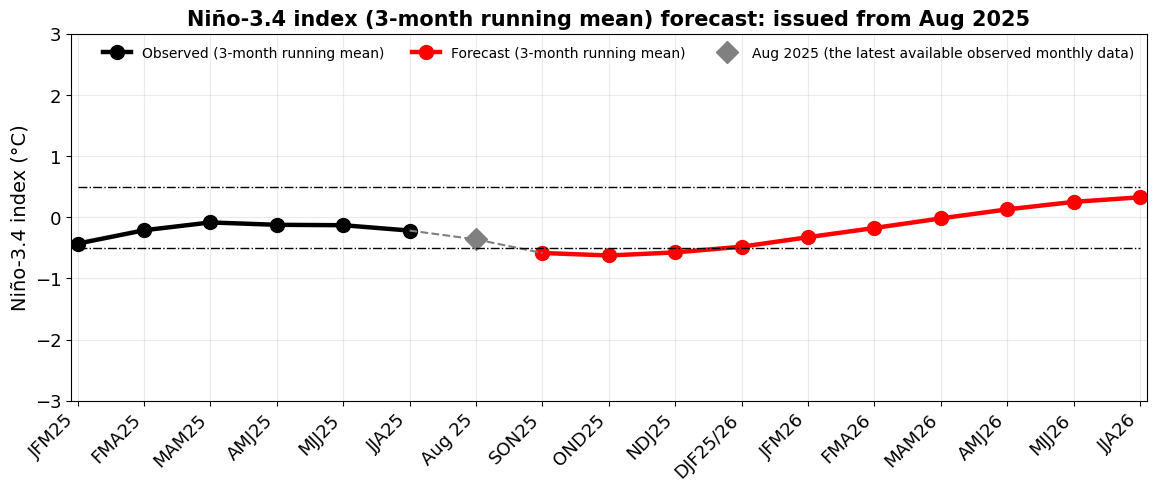

In [53]:
def ensure_time_coord(da: xr.DataArray) -> xr.DataArray:
    """Rename the time-like dimension/coord to 'time' if needed."""
    for cand in ("time", "time_counter", "Time", "t", "date"):
        if cand in da.dims or cand in da.coords:
            return da if cand == "time" else da.rename({cand: "time"})
    raise KeyError(f"No time coordinate found. dims={da.dims}, coords={list(da.coords)}")

MONTH_LET = ["J","F","M","A","M","J","J","A","S","O","N","D"]
def season_label(ts: pd.Timestamp) -> str:
    """e.g., center=2025-01 → DJF24/25, center=2025-09 → SON25."""
    m, y = ts.month, ts.year
    lab = MONTH_LET[(m-2) % 12] + MONTH_LET[(m-1) % 12] + MONTH_LET[m % 12]
    return f"{lab}{(y-1)%100:02d}/{y%100:02d}" if m == 1 else f"{lab}{y%100:02d}"

obs = ensure_time_coord(Nino34_index_ORAS5).rename("nino34")  # xarray.DataArray, monthly
fcst_np = SSTa_real_time_forecast_Wyrtki_CSLIM_Nino34_index   # 1-D numpy array, monthly

# Build forecast time axis from obs
latest_obs_ts = pd.to_datetime(obs["time"].values).max()
fcst_start = (latest_obs_ts + pd.offsets.MonthBegin(1)).normalize()      # month AFTER last obs
fcst_time  = pd.date_range(fcst_start, periods=len(fcst_np), freq="MS")
fcst = xr.DataArray(fcst_np, dims=("time",), coords={"time": fcst_time}, name="nino34")

# 3-mo centered mean
#   - Compute observed 3-month running mean Nino3.4 index from obs only
#   - Compute forecast 3-month running mean Nino3.4 index from combined (obs+fcst) for convenience
oni_obs  = obs.rolling(time=3, center=True, min_periods=3).mean()
combo    = xr.concat([obs, fcst], dim="time").sortby("time")
if combo.indexes["time"].has_duplicates:
    combo = combo.to_series().groupby(level=0).last().to_xarray().rename("nino34")
oni_combo = combo.rolling(time=3, center=True, min_periods=3).mean()

# Observed slice: last 6 fully observed seasons
#   A centered 3-mo mean at center C uses (C-1, C, C+1).
#   To be fully observed, require C+1 <= latest_obs_ts  ⇒  C <= latest_obs_ts - 1 month.
cutoff_center = (latest_obs_ts - pd.offsets.MonthBegin(1)).normalize()
obs_oni_full  = oni_obs.sel(time=slice(None, cutoff_center)).dropna("time")
obs_oni_last6 = obs_oni_full.isel(time=slice(-6, None))  # last 6 seasons (e.g., JFM..JJA if latest is Aug)

# Forecast slice: start at first valid forecast season
#   First forecast 3-month running mean Nino3.4 center = month after fcst_start (needs (fcst_start-1, fcst_start, fcst_start+1))
#   Using combined 3-month running mean Nino3.4 here is fine since it follows the forecast portion.
first_fc_center = (fcst_start + pd.offsets.MonthBegin(1)).normalize()
fcst_oni = oni_combo.sel(time=slice(first_fc_center, None)).dropna("time")

# Single latest observed monthly point (diamond)
latest_obs_val = float(obs.sel(time=latest_obs_ts).values)
latest_obs_label = latest_obs_ts.strftime("%b %y").title()

# Build equal-spaced x axis & labels
x_vals, y_vals, lbls = [], [], []

# 1) observed 3-month running mean Nino3.4 (last 6 only)
obs_times = pd.to_datetime(obs_oni_last6.time.values)
for t, v in zip(obs_times, obs_oni_last6.values):
    x_vals.append(len(x_vals)); y_vals.append(float(v)); lbls.append(season_label(pd.Timestamp(t)))

# 2) latest available monthly point
x_vals.append(len(x_vals)); y_vals.append(latest_obs_val); lbls.append(latest_obs_label)

# 3) forecast 3-month running mean Nino3.4 
fc_times = pd.to_datetime(fcst_oni.time.values)
for t, v in zip(fc_times, fcst_oni.values):
    x_vals.append(len(x_vals)); y_vals.append(float(v)); lbls.append(season_label(pd.Timestamp(t)))

# split indices for styling
n_obs = len(obs_times)
idx_month = n_obs
idx_fc_start = n_obs + 1

x_obs = np.arange(n_obs);             y_obs = np.array(y_vals[:n_obs])
x_month = [idx_month];                y_month = [y_vals[idx_month]]
x_fc  = np.arange(idx_fc_start, len(x_vals));  y_fc  = np.array(y_vals[idx_fc_start:])


plt.rcParams.update({"axes.grid": True, "grid.alpha": 0.25, "font.size": 12})
fig, ax = plt.subplots(figsize=(11.5, 4.8), constrained_layout=True)

ax.plot(x_obs,  y_obs,  marker="o", ms=10, lw=3.2, color="k", label="Observed (3-month running mean)")
ax.plot(x_fc,   y_fc,   marker="o", ms=10, lw=3.2, color="r", label="Forecast (3-month running mean)")
ax.plot(x_month,y_month,marker="D", ms=11, lw=0,  color="grey", label=f"{latest_obs_ts.strftime('%b %Y')} (the latest available observed monthly data)")
ax.plot([x_obs[-1], x_month[0]], [y_obs[-1], y_month[0]], color="grey", ls="--", lw=1.5)
if len(x_fc) > 0:
    ax.plot([x_month[0], x_fc[0]], [y_month[0], y_fc[0]], color="grey", ls="--", lw=1.5)

n = len(lbls)
ax.plot(np.arange(n),  0.5*np.ones(n), color="k", ls="-.", lw=1)
ax.plot(np.arange(n), -0.5*np.ones(n), color="k", ls="-.", lw=1)

ax.set_xticks(np.arange(n))
ax.set_xticklabels(lbls, rotation=45, ha="right")
ax.set_xlim(-0.1, n-0.9)
ax.set_ylim(-3, 3)
ax.set_ylabel("Niño-3.4 index (°C)", fontsize = 14)
ax.set_title(f"Niño-3.4 index (3-month running mean) forecast: issued from {latest_obs_ts.strftime('%b %Y')}",fontweight='bold')
ax.legend(ncol=3, frameon=False, fontsize = 10)

plt.show()


# (Optional) Check the optimal initial conditions and evolutions to indentify the predictability source

In [54]:
# Load the pre-computed SST and SSHa directly

baseurl = "https://uhslc.soest.hawaii.edu/opendap/ORAS5_LIM_ENSO"

SSTa_ORAS5_quadratic_detrend_21yr_rmclim = xr.open_dataset(f"{baseurl}/SSTa_ORAS5_quadetrend_21yr_rmclim_19582024.nc")
SSTa_ORAS5_quadratic_detrend_21yr_rmclim = SSTa_ORAS5_quadratic_detrend_21yr_rmclim['SST']
SSHa_ORAS5_quadratic_detrend_21yr_rmclim = xr.open_dataset(f"{baseurl}/SSHa_ORAS5_quadetrend_21yr_rmclim_19582024.nc")
SSHa_ORAS5_quadratic_detrend_21yr_rmclim = SSHa_ORAS5_quadratic_detrend_21yr_rmclim['SSH']

# select the global SST domain used for the LIM training: 40°S–30°N
SSTa_40S30N = SSTa_ORAS5_quadratic_detrend_21yr_rmclim.sel(lat=slice(-40,30))

# select the tropical Pacific domain for SSHa: 120°E–80°W, 20°S–20°N
# Normalize longitudes to 0–360 so the box (120–280) is contiguous across the dateline
lon0 = (SSHa_ORAS5_quadratic_detrend_21yr_rmclim['lon'].values % 360)
order = np.argsort(lon0)
lon_sorted = lon0[order]
# Drop any duplicate longitudes (e.g., both -180 and 180 -> 180)
dup = np.concatenate(([False], np.isclose(np.diff(lon_sorted), 0)))
keep = ~dup
SSHa_ORAS5_19582024_newlon = SSHa_ORAS5_quadratic_detrend_21yr_rmclim.isel(lon=order).assign_coords(lon=lon_sorted).isel(lon=keep)

SSHa_tropicalPacific = SSHa_ORAS5_19582024_newlon.sel(lat=slice(-20,20),lon=slice(120, 280))

In [55]:
lat1d = SSTa_40S30N['lat'].values
lon1d = SSTa_40S30N['lon'].values
data3d = SSTa_40S30N.values  # shape (T, Ny, Nx)
T, Ny, Nx = data3d.shape

In [56]:
# Run EOF analysis (uses sqrt(cos(lat)) weights)
n_modes_for_example = 9  # choose how many modes you want
pcs, eofs_flat, fve, mask2d = EOF(
    data=data3d,
    lat1d=lat1d,
    n_modes=n_modes_for_example,
    mask=None,          # auto: valid at ALL timesteps
    weight="sqrtcos"    # latitude weighting
)

In [57]:
SSHa_WWV_box = SSHa_tropicalPacific.sel(
    lat=slice(-5, 5),
    lon=slice(120, 280)   # 120E → 280E (equivalent to 80W)
)

# calculate the WWV time series
SSHa_WWV_series = area_mean(
    SSHa_WWV_box,
    lat_bounds=(-5, 5),
    lon_bounds=(120, 280)   # 120°E to 80°W
)


In [58]:
SSTa_EOF_number_in_CSLIM = 9
state_vector_column_CSLIM = SSTa_EOF_number_in_CSLIM + 1 # the "1" represents the warm water volume proxy series

In [59]:
# Calculate the standard deviation of PCs based on EOF analysis of SSTa during 1958-2024
std_SSTa_pcs = pcs[:, :SSTa_EOF_number_in_CSLIM].std()

# Rescale the basin-averaged equatorial Pacific SSHa by the standard deviation of PCs based on EOF analysis of SSTa during 1958-2024
SSHa_WWV_series_norm = SSHa_WWV_series / np.std(SSHa_WWV_series)
SSHa_WWV_series_rescaled_CSLIM = (SSHa_WWV_series_norm * std_SSTa_pcs).values

# CSLIM is trained on 1958-2024
pc_train_CSLIM = np.concatenate([SSHa_WWV_series_rescaled_CSLIM[None, :], pcs[:, :SSTa_EOF_number_in_CSLIM].T], axis=0)


In [60]:
# Reshape the state vectors by calendar month
pc_train_CSLIM_reshaped = reshape_state_vector(pc_train_CSLIM)

print("pc_train_CSLIM_reshaped:", pc_train_CSLIM_reshaped.shape)


pc_train_CSLIM_reshaped: (10, 67, 12)


In [61]:
# Initialize and fit Wyrtki-CSLIM with specified settings:

#   - x_CSLIM_training: State vector for CSLIM training, shape: (spatial_length, n_cycles, period_T)
#   - period_T: seasonal cycle length (12 months)
#   - tolerance_for_Q_negative_eigenvalue_number: threshold for handling negative eigenvalues

period_T = 12
tolerance_for_Q_negative_eigenvalue_number = 0.5

Wyrtki_CSLIM = CSLIM(pc_train_CSLIM_reshaped, period_T = period_T, tolerance_for_Q_negative_eigenvalue_number = tolerance_for_Q_negative_eigenvalue_number)


In [62]:
# Wyrtki_CSLIM1 stability check:
monodromy_matrix_Mj_CSLIM = Wyrtki_CSLIM.monodromy_matrix_Mj()
Qj_CSLIM, Qj_eigenvalues_CSLIM, Qj_eigenvectors_CSLIM, Qj_original_negtive_eigenvalue_number_CSLIM, Qj_original_CSLIM, Qj_original_eigenvalues_CSLIM = Wyrtki_CSLIM.noise_covariance_Qj()

/tmp/ipykernel_1923713/3095943128.py:3: RuntimeWarning: Adjusted Q1: negative eigenvalues were clipped to 0 and positive eigenvalues were rescaled to preserve tr(Qj).
  Qj_CSLIM, Qj_eigenvalues_CSLIM, Qj_eigenvectors_CSLIM, Qj_original_negtive_eigenvalue_number_CSLIM, Qj_original_CSLIM, Qj_original_eigenvalues_CSLIM = Wyrtki_CSLIM.noise_covariance_Qj()
/tmp/ipykernel_1923713/3095943128.py:3: RuntimeWarning: Adjusted Q2: negative eigenvalues were clipped to 0 and positive eigenvalues were rescaled to preserve tr(Qj).
  Qj_CSLIM, Qj_eigenvalues_CSLIM, Qj_eigenvectors_CSLIM, Qj_original_negtive_eigenvalue_number_CSLIM, Qj_original_CSLIM, Qj_original_eigenvalues_CSLIM = Wyrtki_CSLIM.noise_covariance_Qj()
/tmp/ipykernel_1923713/3095943128.py:3: RuntimeWarning: Adjusted Q3: negative eigenvalues were clipped to 0 and positive eigenvalues were rescaled to preserve tr(Qj).
  Qj_CSLIM, Qj_eigenvalues_CSLIM, Qj_eigenvectors_CSLIM, Qj_original_negtive_eigenvalue_number_CSLIM, Qj_original_CSLIM, Qj

In [63]:
optimization_time = np.arange(1,12+1)
target_final_condtion_index = 12 # for December
spatial_length = pc_train_CSLIM_reshaped.shape[0]
initial_norm_vector = None
final_norm_vector = [0,1,0,0,0,0,0,0,0,0]
# final_norm_vector = np.zeros(spatial_length)
# final_norm_vector[1:] = fake_pc_for_eof1_masked.ravel()
# initial_norm_vector = final_norm_vector

maximum_amplification_factor_CSLIM = np.zeros(optimization_time.shape[0])
optimal_inital_condition_CSLIM_targetDec = np.zeros((optimization_time.shape[0],spatial_length))
evoloved_targeted_final_condition_CSLIM = np.zeros((optimization_time.shape[0],spatial_length))

for iopt, optimization_time_i in enumerate(optimization_time):
    optimization_time_i = int(optimization_time_i)
    maximum_amplification_factor_CSLIM[iopt], optimal_inital_condition_CSLIM_targetDec[iopt],evoloved_targeted_final_condition_CSLIM[iopt] = Wyrtki_CSLIM.optimal_initial_condition(optimization_time=optimization_time_i, target_final_condtion_j_index=target_final_condtion_index, initial_norm_vector=initial_norm_vector, final_norm_vector=final_norm_vector)

In [64]:
# Reconstruct SSTa (kept/flattened grid space)
ocean_grid_number = eofs_flat.shape[1]
optimal_inital_condition_CSLIM_grid = np.zeros((optimization_time.shape[0],ocean_grid_number))
optimal_inital_condition_CSLIM_grid2d = np.zeros((optimization_time.shape[0], Ny, Nx))
evoloved_targeted_final_condition_CSLIM_grid = np.zeros((optimization_time.shape[0],ocean_grid_number))
evoloved_targeted_final_condition_CSLIM_grid2d = np.zeros((optimization_time.shape[0], Ny, Nx))

for iopt in range(optimization_time.shape[0]):
    for ieof in range(SSTa_EOF_number_in_CSLIM):
        # forecast_CSLIM[ieof+1,...] is because index 0 holds WWV, not an SST PC, SST PCs start at index 1
        optimal_inital_condition_CSLIM_grid[iopt] = optimal_inital_condition_CSLIM_grid[iopt] + optimal_inital_condition_CSLIM_targetDec[iopt,ieof+1]*eofs_flat[ieof]
        evoloved_targeted_final_condition_CSLIM_grid[iopt] = evoloved_targeted_final_condition_CSLIM_grid[iopt] + evoloved_targeted_final_condition_CSLIM[iopt,ieof+1]*eofs_flat[ieof]
    optimal_inital_condition_CSLIM_grid2d[iopt] = rebuild_eof_on_grid(optimal_inital_condition_CSLIM_grid[iopt], mask2d)
    evoloved_targeted_final_condition_CSLIM_grid2d[iopt] = rebuild_eof_on_grid(evoloved_targeted_final_condition_CSLIM_grid[iopt], mask2d)

In [65]:
# ----- longitude handling: start at 20°E -----
lon_deg = (lon1d % 360)
lon_unique, idx_keep = np.unique(np.round(lon_deg, 10), return_index=True)
lon_shift = (lon_unique - 20.0) % 360.0
sort_idx = np.argsort(lon_shift)
reorder = idx_keep[sort_idx]
lon_sorted = lon_unique[sort_idx]
lon_plot = np.where(lon_sorted < 20.0, lon_sorted + 360.0, lon_sorted)  # 20..380
Lon_c, Lat = np.meshgrid(lon_plot, lat1d)

arr1_sorted = evoloved_targeted_final_condition_CSLIM_grid2d[:, :, reorder]   # (12, lat, lon_sorted)
arr2_sorted = optimal_inital_condition_CSLIM_grid2d[:, :, reorder]            # (12, lat, lon_sorted)

/tmp/ipykernel_1923713/968589506.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r').copy(); cmap.set_bad('0.7')
/tmp/ipykernel_1923713/968589506.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r').copy(); cmap.set_bad('0.7')


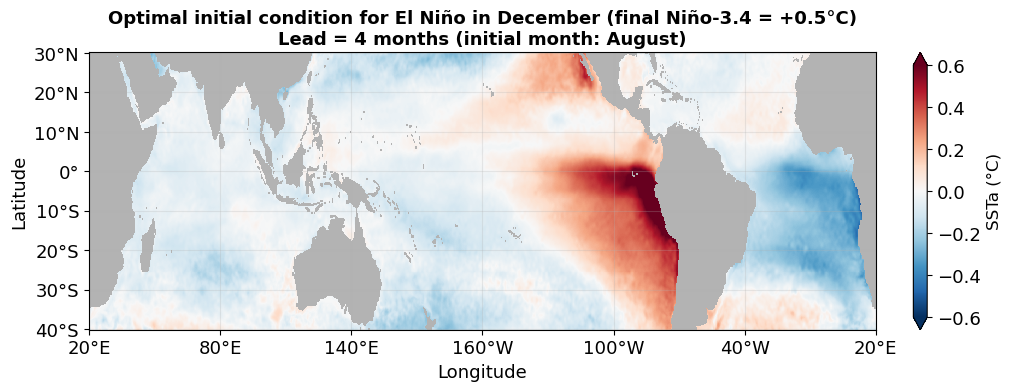

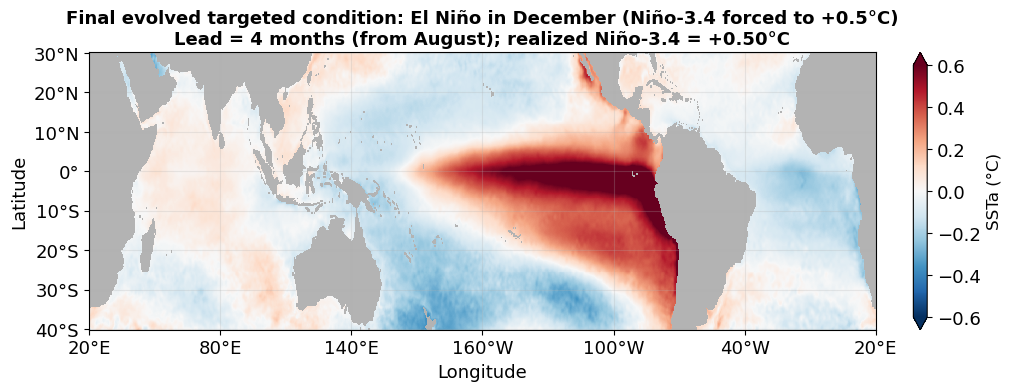

In [66]:
# For El Niño

# ---- parameters ----
target_amp = 0.5  # °C
n34_lat_bounds = (-5, 5)
n34_lon_bounds = (190, 240)  # degE on 20..380 grid

# ---- compute scalers per lead using your area_mean ----
nleads = arr1_sorted.shape[0]
scalers = np.ones(nleads, dtype=float)

for i in range(nleads):
    # wrap the i-th final field into an xarray DataArray on the reordered lon
    da_final = xr.DataArray(
        arr1_sorted[i], dims=("lat", "lon"),
        coords={"lat": lat1d, "lon": lon_sorted}
    )
    m = area_mean(da_final, n34_lat_bounds, n34_lon_bounds).item()  # scalar float

    scalers[i] = target_amp / m

# ---- apply the same scaler to both final & initial fields ----
arr1_scaled = arr1_sorted * scalers[:, None, None]
arr2_scaled = arr2_sorted * scalers[:, None, None]

# ---- shared color scale (robust symmetric) ----
cmap = cm.get_cmap('RdBu_r').copy(); cmap.set_bad('0.7')
# vmax = np.nanpercentile(np.abs(np.concatenate([arr1_scaled, arr2_scaled], axis=0)), 99)
vmax = 0.6
vmin = -vmax

# ---- plotting (example for the finals; mirror for initials as you already do) ----
month_names = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']
target_month_idx = 11  # December
lead_vals = np.arange(12, 0, -1)
def fmt_lon(x):
    d = ((x + 180) % 360) - 180
    if abs(d) < 1e-9: return "0°"
    hemi = "E" if d > 0 else "W"
    return f"{abs(int(d))}°{hemi}"

xticks = [20, 80, 140, 200, 260, 320, 380]
xticklabels = [fmt_lon(x) for x in xticks]
yticks = [-40, -30, -20, -10, 0, 10, 20, 30]
yticklabels = ['40°S','30°S','20°S','10°S','0°','10°N','20°N','30°N']

month_names = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']
target_month_idx = 11  # December

# Niño-3.4 region
n34_lat_bounds = (-5, 5)
n34_lon_bounds = (190, 240)  # degE on 20..380 axis

def area_mean(da, lat_bounds, lon_bounds):
    sub = da.sel(lat=slice(*sorted(lat_bounds)),
                 lon=slice(*sorted(lon_bounds)))
    weights = np.cos(np.deg2rad(sub.lat))
    return (sub * weights).mean(dim=['lat', 'lon'])

# ---- choose latest available ORAS5 initial month (HST rule) ----
now_hst = datetime.now(ZoneInfo("Pacific/Honolulu"))
if now_hst.day >= 15:
    init_idx = (now_hst.month - 2) % 12   # previous month
else:
    init_idx = (now_hst.month - 3) % 12   # two months back
init_label = month_names[init_idx]

# lead from initial -> December (1..12), index into arrays (0..11)
lead = (target_month_idx - init_idx) % 12
lead = 12 if lead == 0 else lead
idx = lead - 1

# ---- colormap and ranges ----
cmap = cm.get_cmap('RdBu_r').copy(); cmap.set_bad('0.7')
vmax_init  = 0.2 if idx >= 6 else 0.6
vmin_init  = -vmax_init
vmax_final = 0.6
vmin_final = -vmax_final

# ========= PLOT 1: Initial (chosen latest month) FIRST =========
field_init = arr2_scaled[idx]
fig, ax = plt.subplots(figsize=(10, 3.8), constrained_layout=True)
pcm = ax.pcolormesh(Lon_c, Lat, field_init, cmap=cmap, shading='auto',
                    vmin=vmin_init, vmax=vmax_init)
ax.set_title(
    "Optimal initial condition for El Niño in December (final Niño-3.4 = +0.5°C)\n"
    f"Lead = {lead} month{'s' if lead>1 else ''} (initial month: {init_label})",
    fontsize=13, fontweight='bold', linespacing=1.2
)
ax.set_xlim(20, 380)
ax.set_xticks(xticks); ax.set_xticklabels(xticklabels)
ax.set_yticks(yticks); ax.set_yticklabels(yticklabels)
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
cbar = fig.colorbar(pcm, ax=ax, fraction=0.03, pad=0.02, extend='both')
cbar.set_label('SSTa (°C)', fontsize=12)
plt.show()

# ========= PLOT 2: Final (December) SECOND =========
field_final = arr1_scaled[idx]
da_show_final = xr.DataArray(field_final, dims=("lat","lon"),
                             coords={"lat": lat1d, "lon": lon_sorted})
n34_after = area_mean(da_show_final, n34_lat_bounds, n34_lon_bounds).item()

fig, ax = plt.subplots(figsize=(10, 3.8), constrained_layout=True)
pcm = ax.pcolormesh(Lon_c, Lat, field_final, cmap=cmap, shading='auto',
                    vmin=vmin_final, vmax=vmax_final)
ax.set_title(
    "Final evolved targeted condition: El Niño in December (Niño-3.4 forced to +0.5°C)\n"
    f"Lead = {lead} month{'s' if lead>1 else ''} (from {init_label}); "
    f"realized Niño-3.4 = {n34_after:+.2f}°C",
    fontsize=13, fontweight='bold', linespacing=1.2
)
ax.set_xlim(20, 380)
ax.set_xticks(xticks); ax.set_xticklabels(xticklabels)
ax.set_yticks(yticks); ax.set_yticklabels(yticklabels)
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
cbar = fig.colorbar(pcm, ax=ax, fraction=0.03, pad=0.02, extend='both')
cbar.set_label('SSTa (°C)', fontsize=12)
plt.show()


/tmp/ipykernel_1923713/3391020017.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r').copy(); cmap.set_bad('0.7')
/tmp/ipykernel_1923713/3391020017.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r').copy(); cmap.set_bad('0.7')


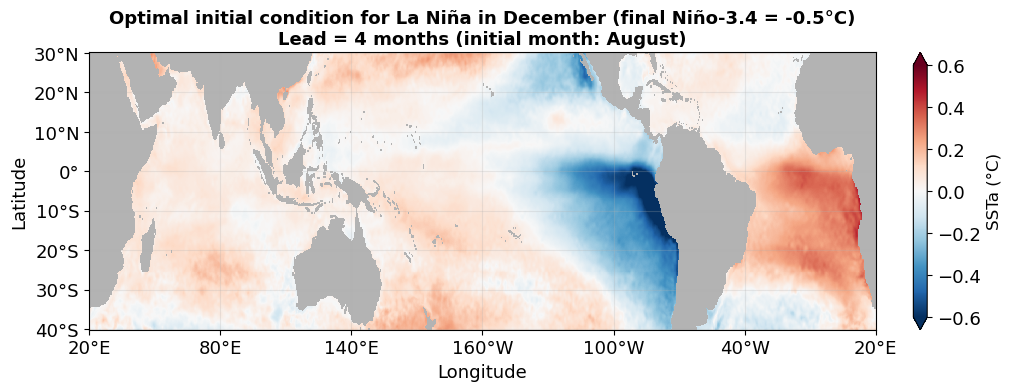

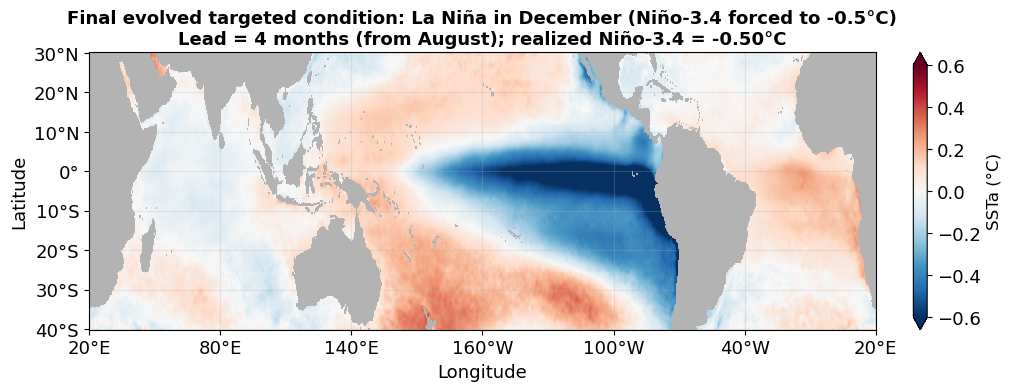

In [67]:
# For La Niña

# ---- parameters ----
target_amp = -0.5  # °C
n34_lat_bounds = (-5, 5)
n34_lon_bounds = (190, 240)  # degE on 20..380 grid

# ---- compute scalers per lead using your area_mean ----
nleads = arr1_sorted.shape[0]
scalers = np.ones(nleads, dtype=float)

for i in range(nleads):
    # wrap the i-th final field into an xarray DataArray on the reordered lon
    da_final = xr.DataArray(
        arr1_sorted[i], dims=("lat", "lon"),
        coords={"lat": lat1d, "lon": lon_sorted}
    )
    m = area_mean(da_final, n34_lat_bounds, n34_lon_bounds).item()  # scalar float
    scalers[i] = target_amp / m

# ---- apply the same scaler to both final & initial fields ----
arr1_scaled = arr1_sorted * scalers[:, None, None]
arr2_scaled = arr2_sorted * scalers[:, None, None]

# ---- shared color scale (robust symmetric) ----
cmap = cm.get_cmap('RdBu_r').copy(); cmap.set_bad('0.7')
# vmax = np.nanpercentile(np.abs(np.concatenate([arr1_scaled, arr2_scaled], axis=0)), 99)
vmax = 0.6
vmin = -vmax

# ---- plotting (example for the finals; mirror for initials as you already do) ----
month_names = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']
target_month_idx = 11  # December
lead_vals = np.arange(12, 0, -1)
def fmt_lon(x):
    d = ((x + 180) % 360) - 180
    if abs(d) < 1e-9: return "0°"
    hemi = "E" if d > 0 else "W"
    return f"{abs(int(d))}°{hemi}"

xticks = [20, 80, 140, 200, 260, 320, 380]
xticklabels = [fmt_lon(x) for x in xticks]
yticks = [-40, -30, -20, -10, 0, 10, 20, 30]
yticklabels = ['40°S','30°S','20°S','10°S','0°','10°N','20°N','30°N']

month_names = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']
target_month_idx = 11  # December

# Niño-3.4 region
n34_lat_bounds = (-5, 5)
n34_lon_bounds = (190, 240)  # degE on 20..380 axis

def area_mean(da, lat_bounds, lon_bounds):
    sub = da.sel(lat=slice(*sorted(lat_bounds)),
                 lon=slice(*sorted(lon_bounds)))
    weights = np.cos(np.deg2rad(sub.lat))
    return (sub * weights).mean(dim=['lat', 'lon'])

# ---- choose latest available ORAS5 initial month (HST rule) ----
now_hst = datetime.now(ZoneInfo("Pacific/Honolulu"))
if now_hst.day >= 15:
    init_idx = (now_hst.month - 2) % 12   # previous month
else:
    init_idx = (now_hst.month - 3) % 12   # two months back
init_label = month_names[init_idx]

# lead from initial -> December (1..12), index into arrays (0..11)
lead = (target_month_idx - init_idx) % 12
lead = 12 if lead == 0 else lead
idx = lead - 1

# ---- colormap and ranges ----
cmap = cm.get_cmap('RdBu_r').copy(); cmap.set_bad('0.7')
vmax_init  = 0.2 if idx >= 6 else 0.6
vmin_init  = -vmax_init
vmax_final = 0.6
vmin_final = -vmax_final

# ========= PLOT 1: Initial (chosen latest month) FIRST =========
field_init = arr2_scaled[idx]
fig, ax = plt.subplots(figsize=(10, 3.8), constrained_layout=True)
pcm = ax.pcolormesh(Lon_c, Lat, field_init, cmap=cmap, shading='auto',
                    vmin=vmin_init, vmax=vmax_init)
ax.set_title(
    "Optimal initial condition for La Niña in December (final Niño-3.4 = -0.5°C)\n"
    f"Lead = {lead} month{'s' if lead>1 else ''} (initial month: {init_label})",
    fontsize=13, fontweight='bold', linespacing=1.2
)
ax.set_xlim(20, 380)
ax.set_xticks(xticks); ax.set_xticklabels(xticklabels)
ax.set_yticks(yticks); ax.set_yticklabels(yticklabels)
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
cbar = fig.colorbar(pcm, ax=ax, fraction=0.03, pad=0.02, extend='both')
cbar.set_label('SSTa (°C)', fontsize=12)
plt.show()

# ========= PLOT 2: Final (December) SECOND =========
field_final = arr1_scaled[idx]
da_show_final = xr.DataArray(field_final, dims=("lat","lon"),
                             coords={"lat": lat1d, "lon": lon_sorted})
n34_after = area_mean(da_show_final, n34_lat_bounds, n34_lon_bounds).item()

fig, ax = plt.subplots(figsize=(10, 3.8), constrained_layout=True)
pcm = ax.pcolormesh(Lon_c, Lat, field_final, cmap=cmap, shading='auto',
                    vmin=vmin_final, vmax=vmax_final)
ax.set_title(
    "Final evolved targeted condition: La Niña in December (Niño-3.4 forced to -0.5°C)\n"
    f"Lead = {lead} month{'s' if lead>1 else ''} (from {init_label}); "
    f"realized Niño-3.4 = {n34_after:+.2f}°C",
    fontsize=13, fontweight='bold', linespacing=1.2
)
ax.set_xlim(20, 380)
ax.set_xticks(xticks); ax.set_xticklabels(xticklabels)
ax.set_yticks(yticks); ax.set_yticklabels(yticklabels)
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
cbar = fig.colorbar(pcm, ax=ax, fraction=0.03, pad=0.02, extend='both')
cbar.set_label('SSTa (°C)', fontsize=12)
plt.show()
